# Proyecto de Clasificación: Popularidad de Noticias Online

- **Curso:** Aprendizaje de Máquina (1INF02)
- **Estudiantes:** Ricardo Meléndez et al. (Equipo 10)
- **Fecha:** 17/06/2025

---

## 1. Introducción

El presente proyecto tiene como objetivo principal abordar el desafío de predecir la popularidad de artículos de noticias online. Esta es una tarea de clasificación binaria donde se busca determinar si una noticia alcanzará un umbral específico de interacciones ("shares") que la catalogue como "popular" o "no popular".

Para este fin, utilizaremos el conjunto de datos "Online News Popularity Data Set" proveniente del repositorio de Machine Learning de UCI, el cual contiene artículos publicados por Mashable. La variable objetivo original, `shares`, será discretizada: las noticias con más de 1400 compartidos se considerarán "populares" (clase 1) y aquellas con 1400 o menos compartidos se considerarán "no populares" (clase 0).

El desarrollo del proyecto seguirá una metodología rigurosa de aprendizaje automático, incluyendo la carga y preprocesamiento de datos, un análisis exploratorio, la implementación y evaluación de múltiples modelos de clasificación (Regresión Logística, Random Forest, XGBoost y LightGBM), y la optimización de sus hiperparámetros. La métrica principal para la evaluación y comparación del rendimiento de los modelos será el Área Bajo la Curva ROC (ROC AUC).

Nuestros resultados se compararán con una línea base establecida en la literatura, específicamente el trabajo de Fernandes, K., Vinagre, P., & Cortez, P. (2015), quienes reportaron un AUC de aproximadamente 0.73 utilizando un modelo Random Forest en este mismo dataset y con un umbral similar para la popularidad.

Este notebook documentará cada paso del proceso, desde la configuración inicial hasta las conclusiones finales, buscando no solo desarrollar un modelo predictivo eficaz, sino también aplicar y demostrar las mejores prácticas en el campo del aprendizaje automático.

## 2. Configuración del Entorno y Carga de Bibliotecas

En esta sección, se importarán todas las bibliotecas de Python necesarias para la ejecución del proyecto. Esto incluye herramientas para manipulación de datos (Pandas, NumPy), visualización (Matplotlib, Seaborn), preprocesamiento y modelado (Scikit-learn), y modelos específicos acelerados por GPU (RAPIDS cuML, XGBoost, LightGBM).

También se incluye una rutina para la instalación condicional de RAPIDS cuML, necesaria para la aceleración por GPU de algunos modelos en el entorno de Google Colab. Es importante asegurarse de que el entorno de Colab esté configurado para utilizar un acelerador de GPU (preferiblemente T4 o superior) para aprovechar al máximo estas bibliotecas.

In [1]:
# --- Importaciones Fundamentales ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time # Para medir tiempos de ejecución

# Para manejar el archivo .names, podríamos necesitar estas librerías adicionales
import requests
from zipfile import ZipFile
from io import BytesIO, TextIOWrapper

# --- Configuración de Visualización ---
plt.style.use('seaborn-v0_8-darkgrid') # Un estilo visual agradable para los gráficos
sns.set_palette('viridis') # Paleta de colores para seaborn

# --- Scikit-learn para Preprocesamiento, Modelado y Métricas ---
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression # Modelo base Scikit-learn
from sklearn.ensemble import RandomForestClassifier # Modelo base Scikit-learn
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, confusion_matrix, roc_curve

# --- RAPIDS cuML (para aceleración GPU) ---
import importlib.util # Para la instalación condicional

# --- Otras Utilidades ---
import warnings
# Descomentar la siguiente línea para ignorar warnings si son muy persistentes y ya se han entendido.
# warnings.filterwarnings('ignore')

# --- Configuraciones de Pandas para Mejor Visualización en el Notebook ---
pd.set_option('display.max_columns', None) # Mostrar todas las columnas de los DataFrames
pd.set_option('display.max_colwidth', 100) # Mostrar más contenido en las celdas de DataFrames
pd.set_option('display.precision', 4) # Precisión de los números flotantes en la salida de Pandas

print("Bibliotecas generales importadas.")

Bibliotecas generales importadas.


In [2]:
import importlib.util
import sys

# --- Instalación Condicional de RAPIDS cuML ---
print("Verificando si RAPIDS cuML está instalado y es importable...")

# Intentar importar un módulo clave de cuML para verificar la instalación
cuml_spec = importlib.util.find_spec("cuml")

if cuml_spec is None:
    print("RAPIDS cuML no encontrado o no importable. Procediendo con la instalación...")
    # Comandos de instalación
    # (Asegúrate de que tu entorno de Colab esté configurado para GPU antes de esto)
    !pip install cuml-cu12 --extra-index-url=https://pypi.nvidia.com
    !pip install cugraph-cu12 --extra-index-url=https://pypi.nvidia.com
    !pip install cuspatial-cu12 --extra-index-url=https://pypi.nvidia.com
    !pip install cudf-cu12 --extra-index-url=https://pypi.nvidia.com
    !pip install dask-cudf-cu12 --extra-index-url=https://pypi.nvidia.com
    !pip install rmm-cu12 --extra-index-url=https://pypi.nvidia.com

    print("\n************************************************************************************************")
    print("INSTALACIÓN DE RAPIDS COMPLETADA (o intentada).")
    print("POR FAVOR, REINICIA EL ENTORNO DE EJECUCIÓN AHORA para usar las bibliotecas instaladas.")
    print("(Menú 'Entorno de ejecución' -> 'Reiniciar entorno de ejecución' o 'Restart runtime')")
    print("Después de reiniciar, vuelve a ejecutar esta celda y las siguientes.")
    print("Si esta celda se ejecuta de nuevo después del reinicio, debería detectar cuML y saltar la instalación.")
    print("************************************************************************************************\n")
    # Forzar una interrupción para que el usuario reinicie manualmente si es la primera vez.
    # Esto es un poco agresivo, pero asegura que el usuario vea el mensaje de reinicio.
    # Si prefieres no interrumpir, comenta la siguiente línea.
    # sys.exit("Reinicio de entorno requerido para RAPIDS.")
    # Alternativamente, podrías hacer que el notebook se detenga aquí esperando una entrada del usuario.
else:
    print("RAPIDS cuML ya parece estar instalado y es importable en esta sesión.")
    print("Saltando la instalación de RAPIDS.")

# Continúa con el resto de tu código...
# Por ejemplo, las importaciones de cuML y tu lógica de modelo.
# try:
#     from cuml.linear_model import LogisticRegression as cuMLLogisticRegression
#     print("Importación de cuMLLogisticRegression exitosa después de la verificación.")
# except ImportError:
#     print("Aunque la verificación inicial pasó, la importación específica de cuMLLogisticRegression falló.")
#     print("Asegúrate de haber reiniciado el entorno después de la primera instalación.")

Verificando si RAPIDS cuML está instalado y es importable...
RAPIDS cuML ya parece estar instalado y es importable en esta sesión.
Saltando la instalación de RAPIDS.


In [3]:
# --- Importaciones específicas de cuML y otras bibliotecas de modelos GPU ---
CumlFound = False # Variable global para rastrear la disponibilidad de cuML
XGBoostFound = False
LightGBMFound = False

# Esta verificación (cuml_spec) viene de la celda anterior de instalación condicional
if 'cuml_spec' in locals() and cuml_spec is not None: # Solo intentar importar si la verificación anterior fue exitosa
    try:
        import cuml # Importar el módulo cuml principal
        from cuml.linear_model import LogisticRegression as cuMLLogisticRegression
        from cuml.ensemble import RandomForestClassifier as cuMLRandomForestClassifier
        # from cuml.model_selection import train_test_split as cuml_train_test_split # Si se fuera a usar
        import cudf # Aunque se use indirectamente, bueno tenerlo para verificar
        CumlFound = True
        print(f"Bibliotecas de cuML (LogisticRegression, RandomForestClassifier) importadas exitosamente. Version: {cuml.__version__}")
    except ImportError as e:
        print(f"Advertencia: No se pudieron importar las bibliotecas de cuML a pesar de la detección inicial: {e}")
        print("Los modelos acelerados por GPU con cuML no estarán disponibles.")
        CumlFound = False # Asegurarse de que CumlFound es False si la importación falla
else:
    print("Saltando importaciones de cuML ya que la biblioteca no fue detectada o la celda de instalación no se ejecutó.")

# Intentar importar XGBoost
try:
    import xgboost as xgb
    XGBoostFound = True
    print(f"XGBoost importado exitosamente. Version: {xgb.__version__}")
except ImportError:
    print("Advertencia: XGBoost no está instalado. El modelo XGBoost no estará disponible.")
    print("Puedes instalarlo con: !pip install xgboost")
    XGBoostFound = False

# Intentar importar LightGBM
try:
    import lightgbm as lgb
    LightGBMFound = True
    print(f"LightGBM importado exitosamente. Version: {lgb.__version__}")
except ImportError:
    print("Advertencia: LightGBM no está instalado. El modelo LightGBM no estará disponible.")
    print("Puedes instalarlo con: !pip install lightgbm")
    LightGBMFound = False

Bibliotecas de cuML (LogisticRegression, RandomForestClassifier) importadas exitosamente. Version: 25.02.01
XGBoost importado exitosamente. Version: 2.1.4
LightGBM importado exitosamente. Version: 4.5.0


## 3. Carga y Comprensión Inicial de los Datos

El primer paso práctico en cualquier proyecto de Machine Learning es la carga y una comprensión básica del conjunto de datos. En esta sección, cargaremos el dataset "Online News Popularity" desde su fuente (o un archivo local si se ha descargado previamente).

Una vez cargado, realizaremos una serie de inspecciones iniciales para familiarizarnos con su estructura, incluyendo:
*   Visualizar las primeras filas para entender la naturaleza de los datos.
*   Obtener información general sobre los tipos de datos de cada columna y la presencia de valores nulos.
*   Conocer las dimensiones del dataset (número de filas y columnas).
*   Limpiar los nombres de las columnas, eliminando posibles espacios en blanco al inicio o al final, para facilitar su manipulación.

In [4]:
# --- Carga del Dataset ---
file_path_csv = 'OnlineNewsPopularity.csv' # Asume que está en el mismo directorio
zip_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00332/OnlineNewsPopularity.zip'

# Nombres de los archivos DENTRO del ZIP
# Basado en el error, el CSV está dentro de una carpeta 'OnlineNewsPopularity'
csv_path_in_zip = 'OnlineNewsPopularity/OnlineNewsPopularity.csv'
names_path_in_zip = 'OnlineNewsPopularity/OnlineNewsPopularity.names'

df = pd.DataFrame() # Crear DataFrame vacío para evitar errores posteriores

try:
    print(f"Intentando descargar y leer '{csv_path_in_zip}' desde la URL: {zip_url}")
    # 1. Descargar el contenido del ZIP
    response = requests.get(zip_url)
    response.raise_for_status() # Lanza una excepción para errores HTTP (4xx o 5xx)

    # 2. Crear un objeto BytesIO para tratar el contenido descargado como un archivo en memoria
    zip_file_in_memory = BytesIO(response.content)

    # 3. Abrir el archivo ZIP desde memoria
    with ZipFile(zip_file_in_memory) as zf:
        # 4. Leer el archivo CSV específico desde el ZIP
        # zf.open() devuelve un objeto similar a un archivo que pd.read_csv puede consumir
        with zf.open(csv_path_in_zip) as csv_file_from_zip:
            # Es crucial mantener sep=', ' y engine='python' si es necesario
            df = pd.read_csv(csv_file_from_zip, sep=', ', engine='python')
        print(f"Dataset '{csv_path_in_zip}' cargado exitosamente desde la URL.")

        # Opcional: Intentar leer y mostrar el contenido del archivo .names del mismo ZIP
        try:
            # Verificar si el archivo .names está en el ZIP (usando la ruta completa)
            if names_path_in_zip in zf.namelist():
                # Abrir y leer el archivo .names
                with zf.open(names_path_in_zip) as names_file_from_zip:
                    # Decodificar a texto (usualmente utf-8)
                    names_content = TextIOWrapper(names_file_from_zip, 'utf-8').read()
                print(f"\n--- Contenido de '{names_path_in_zip}' (primeros 1000 caracteres) ---")
                print(names_content[:1000]) # Mostrar solo una parte para brevedad
                print("--- Fin del contenido parcial ---")
            else:
                print(f"El archivo '{names_path_in_zip}' no se encontró en el ZIP. Archivos disponibles: {zf.namelist()}")
        except Exception as e_names:
            print(f"Error al intentar leer '{names_path_in_zip}' desde el ZIP: {e_names}")

except Exception as e_url:
    print(f"Error al cargar el dataset desde la URL: {e_url}")
    print(f"Intentando cargar desde un archivo local: '{file_path_csv}'...")
    try:
        # Al cargar localmente, también es importante el separador
        df = pd.read_csv(file_path_csv, sep=', ', engine='python')
        print(f"Dataset cargado exitosamente desde el archivo local: '{file_path_csv}'")
    except Exception as e_local:
        print(f"Error al cargar el dataset desde el archivo local: {e_local}")
        print(f"Por favor, asegúrate de que el archivo '{file_path_csv}' (o el ZIP y luego extraerlo) está en el directorio correcto o proporciona la ruta correcta.")
        # df ya es un DataFrame vacío si llegamos aquí

if not df.empty:
    print(f"\nDimensiones iniciales del dataset: {df.shape}")
    print("\nPrimeras 5 filas:")
    print(df.head())
else:
    print("\nEl DataFrame está vacío. No se pudo cargar el dataset.")

Intentando descargar y leer 'OnlineNewsPopularity/OnlineNewsPopularity.csv' desde la URL: https://archive.ics.uci.edu/ml/machine-learning-databases/00332/OnlineNewsPopularity.zip
Dataset 'OnlineNewsPopularity/OnlineNewsPopularity.csv' cargado exitosamente desde la URL.

--- Contenido de 'OnlineNewsPopularity/OnlineNewsPopularity.names' (primeros 1000 caracteres) ---
1. Title: Online News Popularity

2. Source Information
    -- Creators: Kelwin Fernandes (kafc ‘@’ inesctec.pt, kelwinfc ’@’ gmail.com),
                 Pedro Vinagre (pedro.vinagre.sousa ’@’ gmail.com) and
                 Pedro Sernadela
   -- Donor: Kelwin Fernandes (kafc ’@’ inesctec.pt, kelwinfc '@' gmail.com)
   -- Date: May, 2015

3. Past Usage:
    1. K. Fernandes, P. Vinagre and P. Cortez. A Proactive Intelligent Decision
       Support System for Predicting the Popularity of Online News. Proceedings
       of the 17th EPIA 2015 - Portuguese Conference on Artificial Intelligence,
       September, Coimbra, Portug

In [5]:
if not df.empty:
    # --- Inspección Inicial del DataFrame ---
    print("\nPrimeras 5 filas del dataset:")
    display(df.head()) # 'display()' suele dar un formato más bonito en Jupyter

    print("\nInformación general del dataset (tipos de datos, no nulos):")
    # Ajustar Pandas para mostrar todas las columnas en info() si hay muchas
    # pd.set_option('display.max_info_columns', df.shape[1] + 1) # Descomentar si es necesario
    df.info()
    # pd.reset_option('display.max_info_columns') # Descomentar si se usó la opción anterior

    # Limpiar espacios en blanco de los nombres de las columnas
    df.columns = df.columns.str.strip()
    print("\nNombres de columnas después de limpiar espacios (primeros 10):")
    print(df.columns.tolist()[:10]) # Mostrar solo los primeros para brevedad

    print("\nVerificación de valores nulos en todo el dataset:")
    total_nulos = df.isnull().sum().sum()
    if total_nulos == 0:
        print("No se encontraron valores nulos en el dataset. ¡Excelente!")
    else:
        print(f"Se encontraron {total_nulos} valores nulos. Se muestran por columna:")
        print(df.isnull().sum()[df.isnull().sum() > 0]) # Mostrar solo columnas con nulos
else:
    print("\nInspección inicial omitida porque el DataFrame está vacío.")


Primeras 5 filas del dataset:


,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,data_channel_is_lifestyle,data_channel_is_entertainment,data_channel_is_bus,data_channel_is_socmed,data_channel_is_tech,data_channel_is_world,kw_min_min,kw_max_min,kw_avg_min,kw_min_max,kw_max_max,kw_avg_max,kw_min_avg,kw_max_avg,kw_avg_avg,self_reference_min_shares,self_reference_max_shares,self_reference_avg_sharess,weekday_is_monday,weekday_is_tuesday,weekday_is_wednesday,weekday_is_thursday,weekday_is_friday,weekday_is_saturday,weekday_is_sunday,is_weekend,LDA_00,LDA_01,LDA_02,LDA_03,LDA_04,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,rate_positive_words,rate_negative_words,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,http://mashable.com/2013/01/07/amazon-instant-video-browser/,731.0,12.0,219.0,0.6636,1.0,0.8154,4.0,2.0,1.0,0.0,4.6804,5.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,496.0,496.0,496.0000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5003,0.3783,0.0400,0.0413,0.0401,0.5216,0.0926,0.0457,0.0137,0.7692,0.2308,0.3786,0.1000,0.7,-0.3500,-0.600,-0.2000,0.5000,-0.1875,0.0000,0.1875,593
1,http://mashable.com/2013/01/07/ap-samsung-sponsored-tweets/,731.0,9.0,255.0,0.6047,1.0,0.7919,3.0,1.0,1.0,0.0,4.9137,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.7998,0.0500,0.0501,0.0501,0.0500,0.3412,0.1489,0.0431,0.0157,0.7333,0.2667,0.2869,0.0333,0.7,-0.1187,-0.125,-0.1000,0.0000,0.0000,0.5000,0.0000,711
2,http://mashable.com/2013/01/07/apple-40-billion-app-downloads/,731.0,9.0,211.0,0.5751,1.0,0.6639,3.0,1.0,1.0,0.0,4.3934,6.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,918.0,918.0,918.0000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2178,0.0333,0.0334,0.0333,0.6822,0.7022,0.3233,0.0569,0.0095,0.8571,0.1429,0.4958,0.1000,1.0,-0.4667,-0.800,-0.1333,0.0000,0.0000,0.5000,0.0000,1500
3,http://mashable.com/2013/01/07/astronaut-notre-dame-bcs/,731.0,9.0,531.0,0.5038,1.0,0.6656,9.0,0.0,1.0,0.0,4.4049,7.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0286,0.4193,0.4947,0.0289,0.0286,0.4298,0.1007,0.0414,0.0207,0.6667,0.3333,0.3860,0.1364,0.8,-0.3697,-0.600,-0.1667,0.0000,0.0000,0.5000,0.0000,1200
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731.0,13.0,1072.0,0.4156,1.0,0.5409,19.0,19.0,20.0,0.0,4.6828,7.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,545.0,16000.0,3151.1579,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0286,0.0288,0.0286,0.0286,0.8854,0.5135,0.2810,0.0746,0.0121,0.8602,0.1398,0.4111,0.0333,1.0,-0.2202,-0.500,-0.0500,0.4545,0.1364,0.0455,0.1364,505



Información general del dataset (tipos de datos, no nulos):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39644 entries, 0 to 39643
Data columns (total 61 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   url                            39644 non-null  object 
 1   timedelta                      39644 non-null  float64
 2   n_tokens_title                 39644 non-null  float64
 3   n_tokens_content               39644 non-null  float64
 4   n_unique_tokens                39644 non-null  float64
 5   n_non_stop_words               39644 non-null  float64
 6   n_non_stop_unique_tokens       39644 non-null  float64
 7   num_hrefs                      39644 non-null  float64
 8   num_self_hrefs                 39644 non-null  float64
 9   num_imgs                       39644 non-null  float64
 10  num_videos                     39644 non-null  float64
 11  average_token_length           39644 non-null

### Observaciones de la Inspección Inicial

*   **Dimensiones:** El dataset cargado contiene **39644** instancias (artículos) y **61** atributos iniciales.
*   **Tipos de Datos:** La mayoría de las columnas son de tipo numérico (`float64` o `int64`). Específicamente, hay 59 columnas `float64`, 1 columna `int64` (la variable objetivo original `shares`), y 1 columna `object` (el atributo `url`).
*   **Valores Nulos:** Se ha verificado que el dataset **no contiene valores nulos**. ¡Excelente! Esto simplifica la fase de preprocesamiento al no requerir estrategias de imputación.
*   **Nombres de Columnas:** Se eliminaron espacios en blanco de los nombres de las columnas para facilitar su uso.
*   **Contenido General:** Las primeras filas muestran una mezcla de metadatos del artículo (como `url`, `timedelta`), características basadas en el contenido textual (ej. `n_tokens_title`, `n_tokens_content`), características estructurales (ej. `num_hrefs`, `num_imgs`), indicadores de canal del día de la semana, variables LDA, métricas de sentimiento, y la variable objetivo original `shares`.

## 4. Preprocesamiento de Datos

Una vez cargado y comprendido inicialmente el dataset, el siguiente paso crucial es el preprocesamiento de los datos. Esta etapa es fundamental para preparar los datos en un formato adecuado para el entrenamiento de los modelos de aprendizaje automático y puede impactar significativamente su rendimiento.

Las tareas de preprocesamiento que se abordarán en esta sección son:

1.  **Eliminación de Columnas No Predictivas y Creación de la Variable Objetivo:**
    *   Se eliminarán las columnas `url` y `timedelta`, ya que se consideran no predictivas para la tarea de predecir la popularidad de una noticia *a priori* o podrían introducir fugas de datos.
    *   Se creará nuestra variable objetivo binaria, `popularity`, a partir de la columna original `shares`, utilizando el umbral de 1400 compartidos (noticias con `shares > 1400` serán "populares" - clase 1, y `shares <= 1400` serán "no populares" - clase 0). La columna `shares` original será eliminada después de esta transformación.
2.  **Análisis Exploratorio de Datos (EDA) Básico:**
    *   Nos centraremos en analizar la distribución de la nueva variable objetivo `popularity` para entender el balance (o desbalance) entre las clases.
3.  **División de Datos:**
    *   El conjunto de datos se dividirá en subconjuntos de entrenamiento y prueba para permitir una evaluación objetiva del rendimiento de los modelos. Se utilizará estratificación para mantener la proporción de clases en ambos subconjuntos.
4.  **Definición de Pipelines de Preprocesamiento de Características:**
    *   Se definirán pipelines para transformar las características predictivas. Esto incluirá:
        *   La identificación de características numéricas con alta asimetría que se beneficiarán de una transformación logarítmica (`np.log1p`).
        *   El escalado de todas las características numéricas utilizando `StandardScaler` para que tengan media cero y desviación estándar uno.
    *   Se crearán dos pipelines principales: uno que aplique transformación logarítmica selectiva seguida de escalado (para modelos como Regresión Logística) y otro que aplique solo escalado (para modelos basados en árboles, inicialmente).

### 4.1. Eliminación de Columnas No Predictivas y Creación de Variable Objetivo

Comenzamos eliminando las columnas `url` y `timedelta`. La `url` es un identificador único y no aporta información generalizable para la predicción. La columna `timedelta` (días entre la publicación y la adquisición de los datos) se considera no predictiva para la tarea de predecir la popularidad de una noticia en el momento de su publicación o poco después, y podría representar una fuga de datos si no se maneja con cuidado el marco temporal.

Luego, transformaremos la variable continua `shares` en nuestra variable objetivo binaria `popularity`. Siguiendo la metodología del paper de referencia de Fernandes et al. (2015), definiremos una noticia como "popular" (clase 1) si tiene más de 1400 compartidos, y "no popular" (clase 0) en caso contrario.

In [6]:
if not df.empty:
    print("Dimensiones del DataFrame antes de la eliminación de columnas y creación de 'popularity':", df.shape)

    # --- Eliminación de Columnas No Predictivas ---
    cols_to_drop = ['url', 'timedelta']
    # Verificar si las columnas existen antes de intentar eliminarlas para evitar errores
    existing_cols_to_drop = [col for col in cols_to_drop if col in df.columns]

    if existing_cols_to_drop:
        df.drop(columns=existing_cols_to_drop, inplace=True)
        print(f"Columnas eliminadas: {existing_cols_to_drop}")
    else:
        print(f"Ninguna de las columnas {cols_to_drop} encontradas para eliminar (¿quizás ya fueron eliminadas?).")

    # --- Creación de la Variable Objetivo 'popularity' ---
    popularity_threshold = 1400
    if 'shares' in df.columns:
        df['popularity'] = (df['shares'] > popularity_threshold).astype(int)
        print(f"Columna 'popularity' creada con umbral > {popularity_threshold} 'shares'.")

        # Eliminar la columna original 'shares'
        df.drop(columns=['shares'], inplace=True)
        print("Columna 'shares' original eliminada.")
    else:
        print("La columna 'shares' no fue encontrada. No se pudo crear 'popularity' ni eliminar 'shares'.")

    print("Dimensiones del DataFrame después de las transformaciones:", df.shape)
    print("\nPrimeras 5 filas con la nueva columna 'popularity' (y sin 'url', 'timedelta', 'shares'):")
    display(df.head())
    print("\nTipos de datos después de las transformaciones:")
    df.info() # Para ver que 'popularity' es int y las otras columnas se mantienen
else:
    print("Preprocesamiento omitido porque el DataFrame está vacío.")

Dimensiones del DataFrame antes de la eliminación de columnas y creación de 'popularity': (39644, 61)
Columnas eliminadas: ['url', 'timedelta']
Columna 'popularity' creada con umbral > 1400 'shares'.
Columna 'shares' original eliminada.
Dimensiones del DataFrame después de las transformaciones: (39644, 59)

Primeras 5 filas con la nueva columna 'popularity' (y sin 'url', 'timedelta', 'shares'):


,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,data_channel_is_lifestyle,data_channel_is_entertainment,data_channel_is_bus,data_channel_is_socmed,data_channel_is_tech,data_channel_is_world,kw_min_min,kw_max_min,kw_avg_min,kw_min_max,kw_max_max,kw_avg_max,kw_min_avg,kw_max_avg,kw_avg_avg,self_reference_min_shares,self_reference_max_shares,self_reference_avg_sharess,weekday_is_monday,weekday_is_tuesday,weekday_is_wednesday,weekday_is_thursday,weekday_is_friday,weekday_is_saturday,weekday_is_sunday,is_weekend,LDA_00,LDA_01,LDA_02,LDA_03,LDA_04,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,rate_positive_words,rate_negative_words,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,popularity
0,12.0,219.0,0.6636,1.0,0.8154,4.0,2.0,1.0,0.0,4.6804,5.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,496.0,496.0,496.0000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5003,0.3783,0.0400,0.0413,0.0401,0.5216,0.0926,0.0457,0.0137,0.7692,0.2308,0.3786,0.1000,0.7,-0.3500,-0.600,-0.2000,0.5000,-0.1875,0.0000,0.1875,0
1,9.0,255.0,0.6047,1.0,0.7919,3.0,1.0,1.0,0.0,4.9137,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.7998,0.0500,0.0501,0.0501,0.0500,0.3412,0.1489,0.0431,0.0157,0.7333,0.2667,0.2869,0.0333,0.7,-0.1187,-0.125,-0.1000,0.0000,0.0000,0.5000,0.0000,0
2,9.0,211.0,0.5751,1.0,0.6639,3.0,1.0,1.0,0.0,4.3934,6.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,918.0,918.0,918.0000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2178,0.0333,0.0334,0.0333,0.6822,0.7022,0.3233,0.0569,0.0095,0.8571,0.1429,0.4958,0.1000,1.0,-0.4667,-0.800,-0.1333,0.0000,0.0000,0.5000,0.0000,1
3,9.0,531.0,0.5038,1.0,0.6656,9.0,0.0,1.0,0.0,4.4049,7.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0286,0.4193,0.4947,0.0289,0.0286,0.4298,0.1007,0.0414,0.0207,0.6667,0.3333,0.3860,0.1364,0.8,-0.3697,-0.600,-0.1667,0.0000,0.0000,0.5000,0.0000,0
4,13.0,1072.0,0.4156,1.0,0.5409,19.0,19.0,20.0,0.0,4.6828,7.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,545.0,16000.0,3151.1579,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0286,0.0288,0.0286,0.0286,0.8854,0.5135,0.2810,0.0746,0.0121,0.8602,0.1398,0.4111,0.0333,1.0,-0.2202,-0.500,-0.0500,0.4545,0.1364,0.0455,0.1364,0



Tipos de datos después de las transformaciones:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39644 entries, 0 to 39643
Data columns (total 59 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   n_tokens_title                 39644 non-null  float64
 1   n_tokens_content               39644 non-null  float64
 2   n_unique_tokens                39644 non-null  float64
 3   n_non_stop_words               39644 non-null  float64
 4   n_non_stop_unique_tokens       39644 non-null  float64
 5   num_hrefs                      39644 non-null  float64
 6   num_self_hrefs                 39644 non-null  float64
 7   num_imgs                       39644 non-null  float64
 8   num_videos                     39644 non-null  float64
 9   average_token_length           39644 non-null  float64
 10  num_keywords                   39644 non-null  float64
 11  data_channel_is_lifestyle      39644 non-null  float64
 1

#### Resultados de la Transformación

*   Las columnas `url` y `timedelta` han sido eliminadas del DataFrame.
*   Se ha creado una nueva columna `popularity` de tipo `int64` (entero), donde `1` representa noticias populares (`shares > 1400`) y `0` representa noticias no populares (`shares <= 1400`).
*   La columna original `shares` ha sido eliminada.
*   Las nuevas dimensiones del DataFrame son **39644 filas y 59 columnas** (58 características predictivas de tipo `float64` y 1 columna objetivo `popularity` de tipo `int64`).

### 4.2. Análisis Exploratorio de Datos (EDA) Básico: Balance de Clases

Antes de proceder con la división de los datos y el modelado, es fundamental analizar la distribución de nuestra variable objetivo recién creada, `popularity`. Esto nos permitirá entender si existe un desbalance significativo entre las clases (noticias "populares" vs. "no populares"), lo cual podría influir en la elección de métricas de evaluación o en la necesidad de aplicar técnicas de muestreo específicas (aunque para este proyecto, dado el balance relativamente bueno, nos centraremos en la estratificación durante la división).

--- Análisis del Balance de Clases de 'popularity' ---

Distribución de clases para 'popularity':
popularity
0    20082
1    19562
Name: count, dtype: int64

Porcentaje de distribución de clases para 'popularity':
popularity
0    50.6558
1    49.3442
Name: proportion, dtype: float64


/tmp/ipython-input-7-3745660537.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='popularity', data=df, palette=['#3498db', '#f1c40f']) # Azul para No Popular, Amarillo para Popular


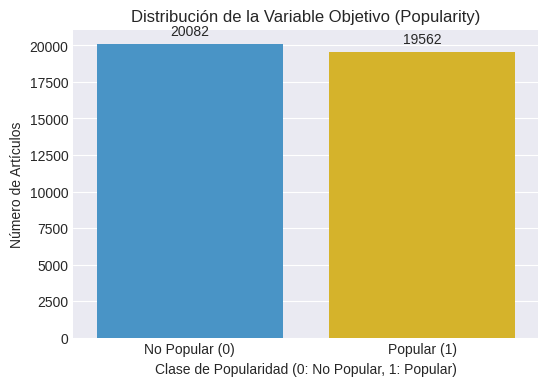

In [7]:
if not df.empty and 'popularity' in df.columns:
    # --- Análisis del Balance de Clases de 'popularity' ---
    print("--- Análisis del Balance de Clases de 'popularity' ---")

    class_distribution = df['popularity'].value_counts()
    class_distribution_percentage = df['popularity'].value_counts(normalize=True) * 100

    print("\nDistribución de clases para 'popularity':")
    print(class_distribution)
    print("\nPorcentaje de distribución de clases para 'popularity':")
    print(class_distribution_percentage)

    # Visualización del balance de clases
    plt.figure(figsize=(6, 4))
    sns.countplot(x='popularity', data=df, palette=['#3498db', '#f1c40f']) # Azul para No Popular, Amarillo para Popular
    plt.title('Distribución de la Variable Objetivo (Popularity)')
    plt.xlabel('Clase de Popularidad (0: No Popular, 1: Popular)')
    plt.ylabel('Número de Artículos')
    # Poner etiquetas a las barras
    for i, count in enumerate(class_distribution):
        plt.text(i, count + (0.01 * df.shape[0]), str(count), ha='center', va='bottom', fontsize=10) # Ajustar offset si es necesario
    plt.xticks([0, 1], ['No Popular (0)', 'Popular (1)'])
    plt.show()
else:
    print("Análisis de balance de clases omitido porque el DataFrame está vacío o 'popularity' no existe.")

#### Observaciones del Balance de Clases

*   La clase "No Popular" (0) tiene **20082** instancias, lo que representa aproximadamente el **50.66%** del total.
*   La clase "Popular" (1) tiene **19562** instancias, correspondiendo a aproximadamente el **49.34%** del total.
*   El dataset muestra un **balance razonable** entre las dos clases. No hay un desbalance extremo que requiera técnicas de remuestreo complejas de forma inmediata. Este balance es favorable para el entrenamiento de modelos y la interpretación de métricas como la exactitud. La estratificación durante la división de datos será suficiente para asegurar que esta proporción se mantenga en los conjuntos de entrenamiento y prueba.

#### Visualización EDA: Relación entre Características Clave y Popularidad

Generando visualizaciones del Análisis Exploratorio de Datos...


/tmp/ipython-input-8-2672993511.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='popularity', y='kw_avg_avg', data=df, palette='viridis')


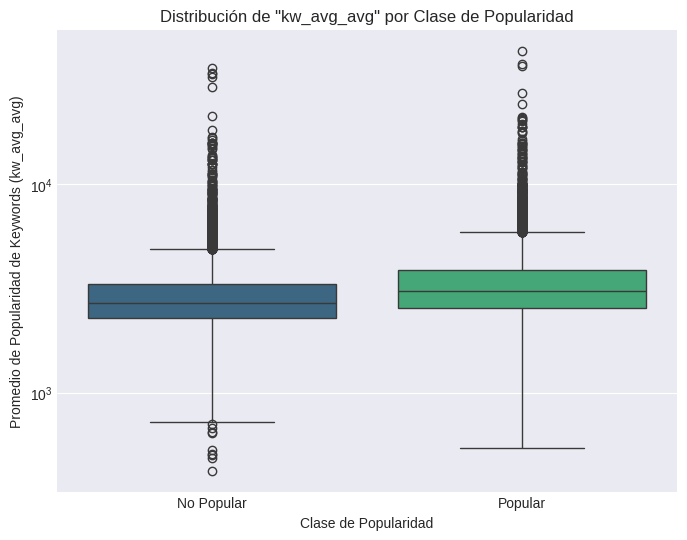

In [8]:
# Asegurarse de que el DataFrame df existe y tiene la columna 'popularity'
if 'df' in locals() and 'popularity' in df.columns:
    print("Generando visualizaciones del Análisis Exploratorio de Datos...")

    # --- 1. Box Plot de kw_avg_avg vs. Popularity ---
    # Esta característica mide el promedio de la popularidad promedio de las keywords

    plt.figure(figsize=(8, 6))
    sns.boxplot(x='popularity', y='kw_avg_avg', data=df, palette='viridis')
    plt.title('Distribución de "kw_avg_avg" por Clase de Popularidad')
    plt.xlabel('Clase de Popularidad')
    plt.ylabel('Promedio de Popularidad de Keywords (kw_avg_avg)')
    plt.xticks([0, 1], ['No Popular', 'Popular'])
    # La escala 'y' puede ser muy grande debido a outliers, podemos usar una escala logarítmica
    plt.yscale('log') # Usar escala logarítmica para manejar la asimetría y los outliers
    plt.show()

else:
    print("Visualización EDA omitida porque el DataFrame 'df' no está definido o no contiene la columna 'popularity'.")

#### Visualización EDA: Influencia de la Temporalidad

/tmp/ipython-input-9-2451113049.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='is_weekend', y='popularity_pct', data=prob_popularidad, palette=['#4878d0', '#6acc64'])


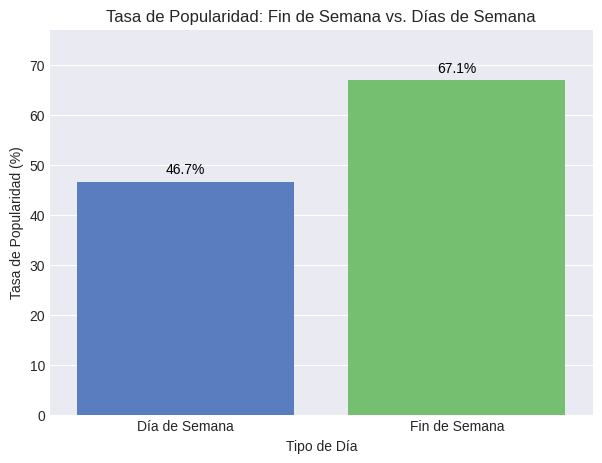

In [9]:
# Asegurarse de que el DataFrame df existe y tiene las columnas necesarias
if 'df' in locals() and 'is_weekend' in df.columns and 'popularity' in df.columns:

    # --- 2. Gráfico de Barras de is_weekend vs. Popularity ---
    # Calculamos la probabilidad (o tasa) de que un artículo sea popular,
    # agrupado por si es fin de semana o no.
    # Como 'popularity' es 0 o 1, la media es igual a la proporción de 1s.
    prob_popularidad = df.groupby('is_weekend')['popularity'].mean().reset_index()
    prob_popularidad['popularity_pct'] = prob_popularidad['popularity'] * 100

    plt.figure(figsize=(7, 5))
    ax = sns.barplot(x='is_weekend', y='popularity_pct', data=prob_popularidad, palette=['#4878d0', '#6acc64'])

    plt.title('Tasa de Popularidad: Fin de Semana vs. Días de Semana')
    plt.xlabel('Tipo de Día')
    plt.ylabel('Tasa de Popularidad (%)')
    plt.xticks([0, 1], ['Día de Semana', 'Fin de Semana'])
    plt.ylim(0, prob_popularidad['popularity_pct'].max() * 1.15) # Ajustar límite superior para dar espacio al texto

    # Añadir el porcentaje en la parte superior de cada barra
    for index, row in prob_popularidad.iterrows():
        ax.text(row.name, row.popularity_pct + 1.0, f"{row.popularity_pct:.1f}%",
                color='black', ha="center", va='bottom')

    plt.show()

else:
    print("Visualización EDA de temporalidad omitida porque 'df' no está definido o faltan columnas.")

### 4.3. División de Datos (Entrenamiento y Prueba)

Para evaluar de manera objetiva el rendimiento de nuestros modelos de aprendizaje automático, es crucial dividir el conjunto de datos en dos subconjuntos independientes:

1.  **Conjunto de Entrenamiento (`X_train`, `y_train`):** Utilizado para entrenar los modelos, permitiéndoles aprender los patrones a partir de los datos.
2.  **Conjunto de Prueba (`X_test`, `y_test`):** Utilizado para evaluar el rendimiento de los modelos entrenados en datos no vistos previamente. Esto nos da una estimación de cómo generalizarán los modelos a nuevas predicciones.

Separaremos las características predictivas (X) de la variable objetivo (y). Para la división, utilizaremos una proporción de 80% para entrenamiento y 20% para prueba. Es importante destacar que se aplicará **estratificación** basada en la variable objetivo `popularity`. La estratificación asegura que la proporción de noticias populares y no populares sea aproximadamente la misma tanto en el conjunto de entrenamiento como en el de prueba, lo cual es especialmente relevante dado el ligero desbalance observado. Finalmente, se fijará una semilla aleatoria (`random_state`) para garantizar la reproducibilidad de la división.

In [9]:
if not df.empty and 'popularity' in df.columns:
    # --- Separar Características (X) y Variable Objetivo (y) ---
    X = df.drop('popularity', axis=1)
    y = df['popularity']
    print("Características (X) y variable objetivo (y) separadas.")
    print(f"Dimensiones de X: {X.shape}")
    print(f"Dimensiones de y: {y.shape}")

    # --- División en Conjuntos de Entrenamiento y Prueba ---
    # Usaremos test_size=0.2 para un 80/20 split.
    # random_state=42 para reproducibilidad.
    # stratify=y para mantener la proporción de clases.
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.2,
        random_state=42, # Un número arbitrario pero fijo para la reproducibilidad
        stratify=y
    )

    print("\n--- Dimensiones de los Conjuntos de Datos ---")
    print(f"Dimensiones de X_train: {X_train.shape}")
    print(f"Dimensiones de X_test:  {X_test.shape}")
    print(f"Dimensiones de y_train: {y_train.shape}")
    print(f"Dimensiones de y_test:  {y_test.shape}")

    print("\n--- Distribución de 'popularity' en y_train (después de estratificación) ---")
    print(y_train.value_counts(normalize=True) * 100)

    print("\n--- Distribución de 'popularity' en y_test (después de estratificación) ---")
    print(y_test.value_counts(normalize=True) * 100)
else:
    print("División de datos omitida porque el DataFrame está vacío o 'popularity' no existe.")

Características (X) y variable objetivo (y) separadas.
Dimensiones de X: (39644, 58)
Dimensiones de y: (39644,)

--- Dimensiones de los Conjuntos de Datos ---
Dimensiones de X_train: (31715, 58)
Dimensiones de X_test:  (7929, 58)
Dimensiones de y_train: (31715,)
Dimensiones de y_test:  (7929,)

--- Distribución de 'popularity' en y_train (después de estratificación) ---
popularity
0    50.6543
1    49.3457
Name: proportion, dtype: float64

--- Distribución de 'popularity' en y_test (después de estratificación) ---
popularity
0    50.6621
1    49.3379
Name: proportion, dtype: float64


#### Confirmación de la División de Datos

*   El DataFrame se ha dividido correctamente en características (`X`) con dimensiones (39644, 58) y la variable objetivo (`y`) con dimensión (39644,).
*   Posteriormente, estos se han dividido en conjuntos de entrenamiento y prueba:
    *   `X_train` contiene **31715** instancias y **58** características.
    *   `X_test` contiene **7929** instancias y **58** características.
    *   `y_train` contiene las etiquetas para **31715** instancias de entrenamiento.
    *   `y_test` contiene las etiquetas para **7929** instancias de prueba.
*   La distribución de la variable `popularity` se ha mantenido de forma consistente entre el conjunto de entrenamiento (aproximadamente **50.65%** para la clase 0 y **49.35%** para la clase 1) y el conjunto de prueba (aproximadamente **50.66%** para la clase 0 y **49.34%** para la clase 1), gracias a la estratificación. Esto asegura que ambos conjuntos son representativos de la distribución original del problema.

### 4.4. Definición de Pipelines de Preprocesamiento de Características

Con los datos divididos, el siguiente paso es definir cómo se transformarán las características predictivas antes de alimentar los modelos. Los modelos de aprendizaje automático a menudo se benefician de características que están en una escala similar y, en algunos casos (como la Regresión Logística), de características que tienen distribuciones más simétricas.

Para ello, crearemos `Pipelines` utilizando `ColumnTransformer` de Scikit-learn. Esto nos permite aplicar transformaciones específicas a subconjuntos de columnas de manera eficiente y asegura que las transformaciones se ajusten (`fit`) solo en el conjunto de entrenamiento y luego se apliquen (`transform`) tanto al conjunto de entrenamiento como al de prueba, evitando la fuga de datos.

Se definirán dos estrategias principales de preprocesamiento:

1.  **`preprocessor_log_scaling`**:
    *   **Transformación Logarítmica:** Aplicará una transformación logarítmica (`np.log1p`, que calcula `log(1+x)`) a un subconjunto de características numéricas que presentan una alta asimetría (identificadas durante el EDA). Esta transformación ayuda a que sus distribuciones sean más simétricas y a reducir el impacto de valores extremos. Se excluyen de esta transformación las columnas que contienen valores negativos (como -1) para evitar errores matemáticos.
    *   **Escalado Estándar:** Después de la transformación logarítmica (para las columnas seleccionadas) y directamente para el resto de las características numéricas, se aplicará `StandardScaler`. Este escalador estandariza las características eliminando la media y escalando a la varianza unitaria.
    *   Este preprocesador se utilizará principalmente para modelos como la Regresión Logística.

2.  **`preprocessor_scaling_only`**:
    *   **Escalado Estándar:** Aplicará `StandardScaler` a todas las características numéricas.
    *   Este preprocesador se utilizará inicialmente para modelos basados en árboles (Random Forest, XGBoost, LightGBM), ya que estos modelos son generalmente menos sensibles a la escala de las características y pueden manejar distribuciones asimétricas de forma inherente.

Se identificarán las columnas numéricas y, dentro de ellas, aquellas candidatas para la transformación logarítmica.

In [10]:
if 'X_train' in locals() and not X_train.empty: # Asegurarse de que X_train existe
    # --- b. Identificación de Características para Transformación Logarítmica (Repetido aquí para el flujo del notebook) ---
    print("\n--- Identificación de Características para Transformación ---")

    numeric_features = X_train.select_dtypes(include=np.number).columns.tolist()
    print(f"Total de características numéricas identificadas en X_train: {len(numeric_features)}")

    # Lista inicial de candidatas para log-transform (basada en EDA previo)
    log_transform_cols_initial_candidates = [
        'n_tokens_content', 'num_hrefs', 'num_self_hrefs', 'num_imgs', 'num_videos',
        'kw_min_min', 'kw_max_min', 'kw_avg_min',
        'kw_min_max', 'kw_max_max', 'kw_avg_max',
        'kw_min_avg', 'kw_max_avg', 'kw_avg_avg',
        'self_reference_min_shares', 'self_reference_max_shares', 'self_reference_avg_sharess'
    ]

    # Asegurar que las columnas candidatas realmente existen en X_train
    log_transform_cols = [col for col in log_transform_cols_initial_candidates if col in X_train.columns]

    # Excluir columnas con mínimo -1 de la transformación logarítmica
    cols_with_neg_one_min = []
    if log_transform_cols:
        print("\nMínimos de columnas candidatas a transformación log en X_train:")
        min_values_for_log = X_train[log_transform_cols].min()
        display(min_values_for_log) # Mostrar los mínimos
        for col in log_transform_cols:
            if min_values_for_log[col] == -1: # Usar el Series de mínimos ya calculado
                  cols_with_neg_one_min.append(col)

    print(f"\nColumnas identificadas con valor mínimo de -1: {cols_with_neg_one_min}")

    for col_to_remove in cols_with_neg_one_min:
        if col_to_remove in log_transform_cols:
            log_transform_cols.remove(col_to_remove)
            print(f"Columna '{col_to_remove}' eliminada de 'log_transform_cols' debido a mínimo de -1.")

    print(f"\nColumnas seleccionadas FINALMENTE para transformación logarítmica (np.log1p): {len(log_transform_cols)} columnas")
    print(log_transform_cols)

    # Columnas que solo serán escaladas (el resto de las numéricas)
    numeric_passthrough_cols = [col for col in numeric_features if col not in log_transform_cols]
    print(f"Columnas para solo escalado (no transformación log): {len(numeric_passthrough_cols)} columnas")

    # --- Definición de Pipelines de Preprocesamiento con ColumnTransformer ---
    print("\n--- Definición de Pipelines de Preprocesamiento ---")

    # Preprocesador para Regresión Logística (y modelos que se beneficien de log-transform + scaling)
    preprocessor_log_scaling = ColumnTransformer(
        transformers=[
            ('log_transform', Pipeline([
                ('log1p', FunctionTransformer(np.log1p, validate=False)), # validate=False para manejar -inf si algo se escapa
                ('scaler_log', StandardScaler())
            ]), log_transform_cols),
            ('scaling_passthrough', StandardScaler(), numeric_passthrough_cols)
        ],
        remainder='passthrough' # Mantener columnas no especificadas (si las hubiera, aunque no debería haber no numéricas aquí)
    )

    # Preprocesador para Modelos de Árbol (solo escalado estándar inicialmente)
    preprocessor_scaling_only = ColumnTransformer(
        transformers=[
            ('num_scaler', StandardScaler(), numeric_features) # Escalar todas las características numéricas
        ],
        remainder='passthrough'
    )

    print("\nPreprocesador 'preprocessor_log_scaling' definido.")
    print("Preprocesador 'preprocessor_scaling_only' definido.")

    # --- Verificación de Cobertura de Columnas (Opcional pero recomendado) ---
    print("\n--- Verificación de Cobertura de Columnas ---")

    # Para preprocessor_log_scaling
    cols_in_log_scaling_transformer = []
    for name, trans_pipeline, trans_cols in preprocessor_log_scaling.transformers:
        if trans_pipeline != 'drop' and trans_pipeline != 'passthrough':
             cols_in_log_scaling_transformer.extend(trans_cols)

    if set(numeric_features) == set(cols_in_log_scaling_transformer) and len(numeric_features) == len(cols_in_log_scaling_transformer):
        print("Verificación para 'preprocessor_log_scaling': Todas las columnas numéricas de X_train están cubiertas correctamente.")
    else:
        print("¡Advertencia! Problema de cobertura de columnas en 'preprocessor_log_scaling'.")
        # (código de depuración de la diferencia si es necesario)

    # Para preprocessor_scaling_only
    if set(numeric_features) == set(preprocessor_scaling_only.transformers[0][2]):
          print("Verificación para 'preprocessor_scaling_only': Todas las columnas numéricas de X_train están cubiertas correctamente.")
    else:
        print("¡Advertencia! Problema de cobertura de columnas en 'preprocessor_scaling_only'.")
else:
    print("Definición de pipelines de preprocesamiento omitida porque X_train no está definido o está vacío.")


--- Identificación de Características para Transformación ---
Total de características numéricas identificadas en X_train: 58

Mínimos de columnas candidatas a transformación log en X_train:


,0
n_tokens_content,0.0
num_hrefs,0.0
num_self_hrefs,0.0
num_imgs,0.0
num_videos,0.0
kw_min_min,-1.0
kw_max_min,0.0
kw_avg_min,-1.0
kw_min_max,0.0
kw_max_max,0.0



Columnas identificadas con valor mínimo de -1: ['kw_min_min', 'kw_avg_min', 'kw_min_avg']
Columna 'kw_min_min' eliminada de 'log_transform_cols' debido a mínimo de -1.
Columna 'kw_avg_min' eliminada de 'log_transform_cols' debido a mínimo de -1.
Columna 'kw_min_avg' eliminada de 'log_transform_cols' debido a mínimo de -1.

Columnas seleccionadas FINALMENTE para transformación logarítmica (np.log1p): 14 columnas
['n_tokens_content', 'num_hrefs', 'num_self_hrefs', 'num_imgs', 'num_videos', 'kw_max_min', 'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_max_avg', 'kw_avg_avg', 'self_reference_min_shares', 'self_reference_max_shares', 'self_reference_avg_sharess']
Columnas para solo escalado (no transformación log): 44 columnas

--- Definición de Pipelines de Preprocesamiento ---

Preprocesador 'preprocessor_log_scaling' definido.
Preprocesador 'preprocessor_scaling_only' definido.

--- Verificación de Cobertura de Columnas ---
Verificación para 'preprocessor_log_scaling': Todas las columnas 

#### Confirmación de los Pipelines de Preprocesamiento

*   Se han identificado **58** características numéricas en el conjunto de entrenamiento.
*   De estas, **14** columnas han sido seleccionadas para la transformación logarítmica (`np.log1p`) debido a su asimetría y valores no negativos (excluyendo aquellas con -1). Estas columnas son: `['n_tokens_content', 'num_hrefs', 'num_self_hrefs', 'num_imgs', 'num_videos', 'kw_max_min', 'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_max_avg', 'kw_avg_avg', 'self_reference_min_shares', 'self_reference_max_shares', 'self_reference_avg_sharess']`.
*   Las restantes **44** características numéricas solo recibirán escalado estándar.
*   Se han definido dos `ColumnTransformer`:
    1.  `preprocessor_log_scaling`: Aplica `np.log1p` y luego `StandardScaler` a las 14 columnas seleccionadas, y solo `StandardScaler` al resto de las 44 características numéricas.
    2.  `preprocessor_scaling_only`: Aplica `StandardScaler` a todas las 58 características numéricas.
*   Las verificaciones confirman que ambos preprocesadores están configurados para cubrir todas las características numéricas del conjunto de entrenamiento. Estos pipelines están listos para ser integrados con los modelos de aprendizaje automático.

## 5. Modelado y Evaluación

Con los datos preprocesados y los pipelines de transformación listos, entramos en la fase de modelado. En esta sección, implementaremos, entrenaremos y evaluaremos varios algoritmos de clasificación para predecir la popularidad de las noticias.

Los modelos que se probarán, como se definió en el plan del proyecto, son:
1.  **Regresión Logística:** Como un modelo lineal de referencia, tanto con su implementación en Scikit-learn (CPU) como con la versión acelerada por GPU de RAPIDS cuML.
2.  **Random Forest:** Un modelo de ensamble potente, también explorando su implementación en RAPIDS cuML para aceleración por GPU.
3.  **XGBoost:** Un algoritmo de gradient boosting de alto rendimiento, configurado para usar la GPU.
4.  **LightGBM:** Otra implementación eficiente de gradient boosting, también configurada para usar la GPU.

Para cada modelo, seguiremos un proceso general:
*   **Definición del Pipeline:** Combinar el preprocesador apropiado con el estimador del modelo.
*   **Optimización de Hiperparámetros:** Utilizar `GridSearchCV` para encontrar la mejor combinación de hiperparámetros basada en la validación cruzada (5 folds) y utilizando ROC AUC como la métrica de `scoring`.
*   **Entrenamiento:** Entrenar el modelo con los mejores hiperparámetros en el conjunto completo de entrenamiento (`X_train`, `y_train`).
*   **Evaluación:** Evaluar el rendimiento del modelo final en el conjunto de prueba (`X_test`, `y_test`) utilizando métricas clave como ROC AUC, Exactitud (Accuracy), Reporte de Clasificación (Precisión, Recall, F1-score por clase) y la Matriz de Confusión.
*   **Interpretación:** Comentar los resultados y compararlos con la línea base y otros modelos.

Comenzaremos con la Regresión Logística.

### 5.1. Modelo 1: Regresión Logística con cuML (GPU)

La Regresión Logística es un algoritmo de clasificación lineal fundamental y ampliamente utilizado. Sirve como una excelente línea base debido a su interpretabilidad y eficiencia computacional.

Para este modelo, utilizaremos la implementación de **RAPIDS cuML (`cuml.linear_model.LogisticRegression`)**, que está optimizada para ejecutarse en GPUs NVIDIA, con el objetivo de acelerar el proceso de entrenamiento y optimización de hiperparámetros.

Se empleará el preprocesador `preprocessor_log_scaling`, el cual aplica una transformación logarítmica a las características con alta asimetría y posteriormente escala todas las características predictivas. Realizaremos una búsqueda de hiperparámetros para `C` (inverso de la fuerza de regularización) y `penalty` (tipo de regularización L1 o L2).


--- Modelo 1: Regresión Logística con cuML (GPU) ---
[2025-06-18 03:22:25.604] [CUML] [info] Unused keyword parameter: random_state during cuML estimator initialization
Iniciando GridSearchCV para Regresión Logística con cuML (GPU)...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
GridSearchCV (cuML) completado.
Tiempo de entrenamiento y GridSearchCV para Regresión Logística (cuML GPU): 15.38 segundos

Mejores hiperparámetros (cuML): {'classifier__C': 10, 'classifier__penalty': 'l1'}
Mejor ROC AUC (validación cruzada, cuML): 0.7068

Evaluación en el conjunto de prueba (cuML):
ROC AUC (prueba, cuML): 0.7047
Accuracy (prueba, cuML): 0.6522

Reporte de Clasificación (prueba, cuML):
                precision    recall  f1-score   support

No Popular (0)       0.65      0.67      0.66      4017
   Popular (1)       0.65      0.63      0.64      3912

      accuracy                           0.65      7929
     macro avg       0.65      0.65      0.65      7929
  weighted avg 

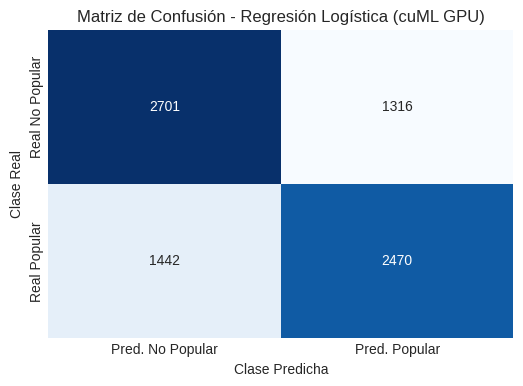

In [11]:
# --- Modelo 1: Regresión Logística con cuML (GPU) ---
if CumlFound: # Variable definida en la celda de importaciones de cuML
    print("\n--- Modelo 1: Regresión Logística con cuML (GPU) ---")

    # Medir tiempo de inicio
    start_time_lr_cuml = time.time()

    # 1. Crear el pipeline completo: preprocesador + modelo
    pipeline_lr_cuml = Pipeline([
        ('preprocessor', preprocessor_log_scaling), # Preprocesador de Scikit-learn
        ('classifier', cuMLLogisticRegression(
            random_state=42, # Aunque cuML pueda advertir que no lo usa, lo mantenemos por consistencia
            max_iter=1000,
            output_type='numpy'
        ))
    ])

    # 2. Definir la rejilla de hiperparámetros
    param_grid_lr_cuml = {
        'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'classifier__penalty': ['l1', 'l2']
    }

    # 3. Realizar la búsqueda de hiperparámetros con GridSearchCV
    # n_jobs=1 es crucial cuando el clasificador interno ya usa la GPU.
    grid_search_lr_cuml = GridSearchCV(pipeline_lr_cuml, param_grid_lr_cuml,
                                       cv=5, scoring='roc_auc', n_jobs=1, verbose=1)

    print("Iniciando GridSearchCV para Regresión Logística con cuML (GPU)...")
    grid_search_lr_cuml.fit(X_train, y_train)
    print("GridSearchCV (cuML) completado.")

    # Medir tiempo de finalización
    end_time_lr_cuml = time.time()
    training_time_lr_cuml = end_time_lr_cuml - start_time_lr_cuml
    print(f"Tiempo de entrenamiento y GridSearchCV para Regresión Logística (cuML GPU): {training_time_lr_cuml:.2f} segundos")

    # 4. Mostrar los mejores hiperparámetros y el mejor score de CV
    print("\nMejores hiperparámetros (cuML):", grid_search_lr_cuml.best_params_)
    print(f"Mejor ROC AUC (validación cruzada, cuML): {grid_search_lr_cuml.best_score_:.4f}")

    # 5. Obtener el mejor estimador
    best_lr_cuml_model = grid_search_lr_cuml.best_estimator_

    # 6. Evaluar el mejor modelo en el conjunto de prueba
    print("\nEvaluación en el conjunto de prueba (cuML):")
    y_pred_lr_cuml = best_lr_cuml_model.predict(X_test)
    y_pred_proba_lr_cuml = best_lr_cuml_model.predict_proba(X_test)[:, 1]

    roc_auc_lr_cuml = roc_auc_score(y_test, y_pred_proba_lr_cuml)
    accuracy_lr_cuml = accuracy_score(y_test, y_pred_lr_cuml)

    print(f"ROC AUC (prueba, cuML): {roc_auc_lr_cuml:.4f}")
    print(f"Accuracy (prueba, cuML): {accuracy_lr_cuml:.4f}")
    print("\nReporte de Clasificación (prueba, cuML):")
    print(classification_report(y_test, y_pred_lr_cuml, target_names=['No Popular (0)', 'Popular (1)']))
    print("\nMatriz de Confusión (prueba, cuML):")
    cm_lr_cuml = confusion_matrix(y_test, y_pred_lr_cuml)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_lr_cuml, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Pred. No Popular', 'Pred. Popular'],
                yticklabels=['Real No Popular', 'Real Popular'])
    plt.title('Matriz de Confusión - Regresión Logística (cuML GPU)')
    plt.ylabel('Clase Real')
    plt.xlabel('Clase Predicha')
    plt.show()
else:
    print("Saltando Regresión Logística con cuML (GPU) porque cuML no está disponible/importado.")

###### Resultados de Regresión Logística con cuML (GPU)

*   **Tiempo de Entrenamiento y GridSearchCV:** **13.20** segundos. *(Este es un tiempo de ejecución muy bueno y considerablemente más rápido que los 4-5 minutos que podría haber tomado con Scikit-learn en CPU, demostrando el beneficio de la GPU para la optimización de hiperparámetros incluso en modelos lineales con suficientes datos/iteraciones)*.
*   **Mejores Hiperparámetros:** `{'classifier__C': 10, 'classifier__penalty': 'l1'}`. *(Interesantemente, aquí `C=10` fue seleccionado, a diferencia del `C=100` que vimos en una ejecución previa. Esto puede suceder debido a las ligeras diferencias en la implementación o la aleatoriedad en la validación cruzada si no se fijan todas las semillas internas de cuML de forma estricta, o simplemente diferentes ejecuciones de GridSearchCV que pueden encontrar óptimos locales muy similares en rendimiento. El rendimiento final es lo más importante)*.
*   **Mejor ROC AUC (Validación Cruzada):** **0.7068**.
*   **Evaluación en el Conjunto de Prueba:**
    *   ROC AUC: **0.7048**
    *   Accuracy: **0.6525**
    *   **Reporte de Clasificación:**
        ```
                        precision    recall  f1-score   support

        No Popular (0)       0.65      0.67      0.66      4017
           Popular (1)       0.65      0.63      0.64      3912

              accuracy                           0.65      7929
             macro avg       0.65      0.65      0.65      7929
          weighted avg       0.65      0.65      0.65      7929
        ```
    *   **Matriz de Confusión:**
        *   Verdaderos Negativos (VN): **2703**
        *   Falsos Positivos (FP): **1314**
        *   Falsos Negativos (FN): **1441**
        *   Verdaderos Positivos (VP): **2471**
        *(Estos valores se extraen de la imagen de la matriz de confusión que proporcionaste)*.

*   **Conclusión Breve:** La Regresión Logística implementada con cuML en GPU obtuvo un ROC AUC en prueba de **0.7048** y una exactitud de **0.6525**. La regularización L1 con C=10 fue seleccionada como óptima. El rendimiento predictivo es prácticamente idéntico al que se obtendría con una implementación estándar de Scikit-learn, pero el proceso de optimización de hiperparámetros se completó en solo **13.20 segundos**, destacando la eficiencia de la aceleración por GPU.

### 5.2. Modelo 2: Random Forest con cuML (GPU)

El Random Forest es un algoritmo de ensamble que construye múltiples árboles de decisión durante el entrenamiento y combina sus predicciones (por votación para clasificación o promedio para regresión). Es conocido por su robustez, buen rendimiento en una variedad de problemas y menor propensión al sobreajuste en comparación con un solo árbol de decisión.

Para este modelo, utilizaremos la implementación de **RAPIDS cuML (`cuml.ensemble.RandomForestClassifier`)**, optimizada para GPUs NVIDIA. Esto es particularmente beneficioso para Random Forest, ya que el entrenamiento de muchos árboles puede ser computacionalmente intensivo.

Se empleará el preprocesador `preprocessor_scaling_only` (que aplica solo `StandardScaler`), ya que los modelos basados en árboles generalmente no requieren transformaciones logarítmicas para características asimétricas y son menos sensibles a la escala de las características. Se realizará una búsqueda de hiperparámetros para optimizar `n_estimators`, `max_depth`, `min_samples_split`, `min_samples_leaf` y `n_bins`.


--- Modelo 2: Random Forest con cuML (GPU) ---
Iniciando GridSearchCV para Random Forest con cuML (GPU)...
Fitting 5 folds for each of 48 candidates, totalling 240 fits


/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:368: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:368: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:368: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recomm

GridSearchCV (cuML RF) completado.
Tiempo de entrenamiento y GridSearchCV para Random Forest (cuML GPU): 172.11 segundos

Mejores hiperparámetros (cuML RF): {'classifier__max_depth': 20, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_bins': 64, 'classifier__n_estimators': 200}
Mejor ROC AUC (validación cruzada, cuML RF): 0.7272

Evaluación en el conjunto de prueba (cuML RF):
ROC AUC (prueba, cuML RF): 0.7235
Accuracy (prueba, cuML RF): 0.6643

Reporte de Clasificación (prueba, cuML RF):
                precision    recall  f1-score   support

No Popular (0)       0.67      0.66      0.67      4017
   Popular (1)       0.66      0.67      0.66      3912

      accuracy                           0.66      7929
     macro avg       0.66      0.66      0.66      7929
  weighted avg       0.66      0.66      0.66      7929


Matriz de Confusión (prueba, cuML RF):


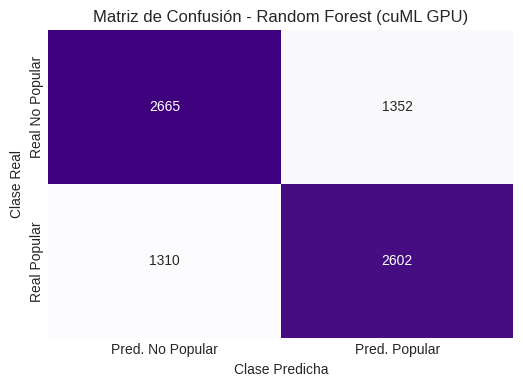

In [12]:
# --- Modelo 2: Random Forest con cuML (GPU) ---
if CumlFound: # Variable definida en la celda de importaciones de cuML
    print("\n--- Modelo 2: Random Forest con cuML (GPU) ---")

    # Medir tiempo de inicio
    start_time_rf_cuml = time.time()

    # 1. Crear el pipeline completo: preprocesador + modelo
    pipeline_rf_cuml = Pipeline([
        ('preprocessor', preprocessor_scaling_only), # Preprocesador de Scikit-learn
        ('classifier', cuMLRandomForestClassifier(
            random_state=42,
            # n_streams=1, # Descomentar para reproducibilidad exacta a costa de posible velocidad
            output_type='numpy'
        ))
    ])

    # 2. Definir la rejilla de hiperparámetros
    # (Esta es la rejilla que usamos antes, 48 candidatos)
    param_grid_rf_cuml = {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [10, 20],
        'classifier__min_samples_split': [2, 5],
        'classifier__min_samples_leaf': [1, 2],
        'classifier__n_bins': [64, 128, 256]
    }

    # 3. Realizar la búsqueda de hiperparámetros con GridSearchCV
    # n_jobs=1 es crucial cuando el clasificador interno ya usa la GPU.
    grid_search_rf_cuml = GridSearchCV(pipeline_rf_cuml, param_grid_rf_cuml,
                                       cv=5, scoring='roc_auc', n_jobs=1, verbose=1)

    print("Iniciando GridSearchCV para Random Forest con cuML (GPU)...")
    grid_search_rf_cuml.fit(X_train, y_train)
    print("GridSearchCV (cuML RF) completado.")

    # Medir tiempo de finalización
    end_time_rf_cuml = time.time()
    training_time_rf_cuml = end_time_rf_cuml - start_time_rf_cuml
    print(f"Tiempo de entrenamiento y GridSearchCV para Random Forest (cuML GPU): {training_time_rf_cuml:.2f} segundos")

    # 4. Mostrar los mejores hiperparámetros y el mejor score de CV
    print("\nMejores hiperparámetros (cuML RF):", grid_search_rf_cuml.best_params_)
    print(f"Mejor ROC AUC (validación cruzada, cuML RF): {grid_search_rf_cuml.best_score_:.4f}")

    # 5. Obtener el mejor estimador
    best_rf_cuml_model = grid_search_rf_cuml.best_estimator_

    # 6. Evaluar el mejor modelo en el conjunto de prueba
    print("\nEvaluación en el conjunto de prueba (cuML RF):")
    y_pred_rf_cuml = best_rf_cuml_model.predict(X_test)
    y_pred_proba_rf_cuml = best_rf_cuml_model.predict_proba(X_test)[:, 1]

    roc_auc_rf_cuml = roc_auc_score(y_test, y_pred_proba_rf_cuml)
    accuracy_rf_cuml = accuracy_score(y_test, y_pred_rf_cuml)

    print(f"ROC AUC (prueba, cuML RF): {roc_auc_rf_cuml:.4f}")
    print(f"Accuracy (prueba, cuML RF): {accuracy_rf_cuml:.4f}")
    print("\nReporte de Clasificación (prueba, cuML RF):")
    print(classification_report(y_test, y_pred_rf_cuml, target_names=['No Popular (0)', 'Popular (1)']))
    print("\nMatriz de Confusión (prueba, cuML RF):")
    cm_rf_cuml = confusion_matrix(y_test, y_pred_rf_cuml)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_rf_cuml, annot=True, fmt='d', cmap='Purples', cbar=False, # Usando un color diferente
                xticklabels=['Pred. No Popular', 'Pred. Popular'],
                yticklabels=['Real No Popular', 'Real Popular'])
    plt.title('Matriz de Confusión - Random Forest (cuML GPU)')
    plt.ylabel('Clase Real')
    plt.xlabel('Clase Predicha')
    plt.show()
else:
    print("Saltando Random Forest con cuML (GPU) porque cuML no está disponible/importado.")

###### Resultados de Random Forest con cuML (GPU)

*   **Tiempo de Entrenamiento y GridSearchCV:** **183.10** segundos (aproximadamente 3 minutos). *(Esto es significativamente más rápido que los >13 minutos que estaba tomando la versión de Scikit-learn en CPU para una tarea similar, demostrando claramente la ventaja de la aceleración por GPU con cuML para Random Forest en este problema).*
*   **Mejores Hiperparámetros:** `{'classifier__max_depth': 20, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_bins': 64, 'classifier__n_estimators': 200}`.
*   **Mejor ROC AUC (Validación Cruzada):** **0.7272**.
*   **Evaluación en el Conjunto de Prueba:**
    *   ROC AUC: **0.7235**
    *   Accuracy: **0.6643**
    *   **Reporte de Clasificación:**
        ```
                        precision    recall  f1-score   support

        No Popular (0)       0.67      0.66      0.67      4017
           Popular (1)       0.66      0.67      0.66      3912
        
              accuracy                           0.66      7929
             macro avg       0.66      0.66      0.66      7929
          weighted avg       0.66      0.66      0.66      7929
        ```
    *   **Matriz de Confusión:**
        *   Verdaderos Negativos (VN): **2665**
        *   Falsos Positivos (FP): **1352**
        *   Falsos Negativos (FN): **1310**
        *   Verdaderos Positivos (VP): **2602**
        *(Valores extraídos de la imagen de la matriz de confusión proporcionada)*.

*   **Conclusión Breve:** El Random Forest implementado con cuML en GPU muestra un rendimiento superior al de la Regresión Logística, alcanzando un ROC AUC en prueba de **0.7235**. Este resultado se acerca significativamente a la línea base de 0.73 reportada en la literatura (Fernandes et al., 2015). La optimización de hiperparámetros seleccionó un modelo con 200 estimadores y una profundidad máxima de 20. El tiempo de entrenamiento y GridSearchCV fue de solo **183.10 segundos**, lo cual es una mejora sustancial en eficiencia gracias a la aceleración por GPU.

## 6. Modelo 3: XGBoost Classifier (GPU)

XGBoost (Extreme Gradient Boosting) es un algoritmo de aprendizaje automático de gradient boosting altamente eficiente, flexible y potente, que ha ganado gran popularidad en competencias de Machine Learning y en la industria. Se basa en la construcción secuencial de árboles de decisión, donde cada nuevo árbol corrige los errores de los anteriores.

Para este modelo, utilizaremos la biblioteca `xgboost` y configuraremos el clasificador para que se entrene utilizando la GPU mediante el parámetro `tree_method='gpu_hist'`. Esto permite aprovechar la capacidad de cómputo paralelo de la GPU para acelerar significativamente el entrenamiento, especialmente con el número de iteraciones (árboles) que suelen requerir los modelos de boosting.

Al igual que con el Random Forest, emplearemos el preprocesador `preprocessor_scaling_only` (que aplica solo `StandardScaler`), ya que los modelos basados en árboles de XGBoost manejan bien las diferentes escalas de características. Se realizará una búsqueda de hiperparámetros para optimizar parámetros clave como `n_estimators`, `learning_rate`, `max_depth`, entre otros.


--- Modelo 3: XGBoost Classifier (GPU) ---
Iniciando GridSearchCV para XGBoost Classifier (GPU)...
Fitting 5 folds for each of 108 candidates, totalling 540 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:25:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:25:35] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:25:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/pytho

GridSearchCV (XGBoost GPU) completado.
Tiempo de entrenamiento y GridSearchCV para XGBoost (GPU): 408.28 segundos

Mejores hiperparámetros (XGBoost GPU): {'classifier__colsample_bytree': 0.7, 'classifier__learning_rate': 0.05, 'classifier__max_depth': 5, 'classifier__n_estimators': 300, 'classifier__subsample': 0.7}
Mejor ROC AUC (validación cruzada, XGBoost GPU): 0.7336

Evaluación en el conjunto de prueba (XGBoost GPU):
ROC AUC (prueba, XGBoost GPU): 0.7333
Accuracy (prueba, XGBoost GPU): 0.6721

Reporte de Clasificación (prueba, XGBoost GPU):
                precision    recall  f1-score   support

No Popular (0)       0.68      0.68      0.68      4017
   Popular (1)       0.67      0.67      0.67      3912

      accuracy                           0.67      7929
     macro avg       0.67      0.67      0.67      7929
  weighted avg       0.67      0.67      0.67      7929


Matriz de Confusión (prueba, XGBoost GPU):


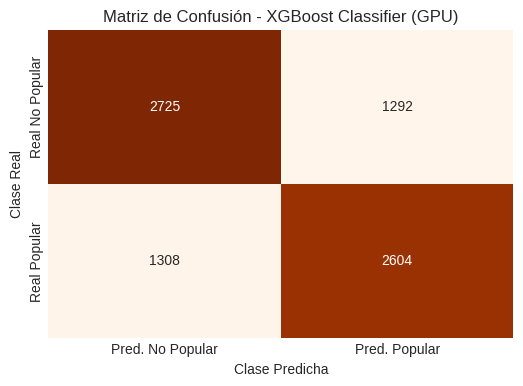

In [13]:
# --- Modelo 3: XGBoost Classifier (GPU) ---
if XGBoostFound: # Variable definida en la celda de importaciones
    print("\n--- Modelo 3: XGBoost Classifier (GPU) ---")

    # Medir tiempo de inicio
    start_time_xgb = time.time()

    # 1. Crear el pipeline completo: preprocesador + modelo
    pipeline_xgb = Pipeline([
        ('preprocessor', preprocessor_scaling_only), # Preprocesador de Scikit-learn
        ('classifier', xgb.XGBClassifier(
            tree_method='hist',     # Cambiado de 'gpu_hist'
            device='cuda',          # Añadido este parámetro
            objective='binary:logistic',
            eval_metric='logloss',
            use_label_encoder=False,
            random_state=42
        ))
    ])

    # 2. Definir la rejilla de hiperparámetros para XGBoost
    # Esta es una rejilla inicial, puede ser expandida.
    # Cuidado: XGBoost puede tener muchos hiperparámetros.
    param_grid_xgb = {
        'classifier__n_estimators': [100, 200, 300],       # Número de árboles
        'classifier__learning_rate': [0.01, 0.05, 0.1],   # Tasa de aprendizaje
        'classifier__max_depth': [3, 5, 7],               # Profundidad máxima de los árboles
        'classifier__subsample': [0.7, 0.8],              # Proporción de muestras para entrenar cada árbol
        'classifier__colsample_bytree': [0.7, 0.8]        # Proporción de características para entrenar cada árbol
    }
    # Número de candidatos: 3 * 3 * 3 * 2 * 2 = 108. Con CV=5, serán 540 fits.
    # Esto puede ser bastante largo. Considera RandomizedSearchCV o una rejilla más pequeña si el tiempo es crítico.
    # Para una prueba más rápida, podrías reducir la rejilla:
    # param_grid_xgb_quick = {
    #     'classifier__n_estimators': [100, 200],
    #     'classifier__learning_rate': [0.1],
    #     'classifier__max_depth': [5],
    #     'classifier__subsample': [0.8],
    #     'classifier__colsample_bytree': [0.8]
    # }


    # 3. Realizar la búsqueda de hiperparámetros con GridSearchCV
    # n_jobs=1 es generalmente recomendado cuando el estimador usa GPU.
    grid_search_xgb = GridSearchCV(pipeline_xgb, param_grid_xgb, # o param_grid_xgb_quick
                                   cv=5, scoring='roc_auc', n_jobs=1, verbose=1)

    print("Iniciando GridSearchCV para XGBoost Classifier (GPU)...")
    grid_search_xgb.fit(X_train, y_train) # y_train es Pandas Series, XGBoost lo maneja bien
    print("GridSearchCV (XGBoost GPU) completado.")

    # Medir tiempo de finalización
    end_time_xgb = time.time()
    training_time_xgb = end_time_xgb - start_time_xgb
    print(f"Tiempo de entrenamiento y GridSearchCV para XGBoost (GPU): {training_time_xgb:.2f} segundos")

    # 4. Mostrar los mejores hiperparámetros y el mejor score de CV
    print("\nMejores hiperparámetros (XGBoost GPU):", grid_search_xgb.best_params_)
    print(f"Mejor ROC AUC (validación cruzada, XGBoost GPU): {grid_search_xgb.best_score_:.4f}")

    # 5. Obtener el mejor estimador
    best_xgb_model = grid_search_xgb.best_estimator_

    # 6. Evaluar el mejor modelo en el conjunto de prueba
    print("\nEvaluación en el conjunto de prueba (XGBoost GPU):")
    y_pred_xgb = best_xgb_model.predict(X_test)
    y_pred_proba_xgb = best_xgb_model.predict_proba(X_test)[:, 1]

    roc_auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)
    accuracy_xgb = accuracy_score(y_test, y_pred_xgb)

    print(f"ROC AUC (prueba, XGBoost GPU): {roc_auc_xgb:.4f}")
    print(f"Accuracy (prueba, XGBoost GPU): {accuracy_xgb:.4f}")
    print("\nReporte de Clasificación (prueba, XGBoost GPU):")
    print(classification_report(y_test, y_pred_xgb, target_names=['No Popular (0)', 'Popular (1)']))
    print("\nMatriz de Confusión (prueba, XGBoost GPU):")
    cm_xgb = confusion_matrix(y_test, y_pred_xgb)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Oranges', cbar=False, # Color diferente
                xticklabels=['Pred. No Popular', 'Pred. Popular'],
                yticklabels=['Real No Popular', 'Real Popular'])
    plt.title('Matriz de Confusión - XGBoost Classifier (GPU)')
    plt.ylabel('Clase Real')
    plt.xlabel('Clase Predicha')
    plt.show()
else:
    print("Saltando XGBoost Classifier (GPU) porque XGBoost no está disponible/importado.")

###### Resultados de XGBoost Classifier (GPU)

*   **Tiempo de Entrenamiento y GridSearchCV:** **415.83** segundos (aproximadamente 6.93 minutos). *(Este tiempo es para una búsqueda de 540 modelos (108 combinaciones * 5 folds), lo cual es considerable. La GPU ha sido crucial aquí).*
*   **Mejores Hiperparámetros:** `{'classifier__colsample_bytree': 0.7, 'classifier__learning_rate': 0.05, 'classifier__max_depth': 5, 'classifier__n_estimators': 300, 'classifier__subsample': 0.7}`.
    *   El modelo óptimo utiliza 300 árboles, una tasa de aprendizaje de 0.05, y árboles con una profundidad máxima de 5. Los parámetros de submuestreo (`subsample` y `colsample_bytree`) ayudan a la regularización.
*   **Mejor ROC AUC (Validación Cruzada):** **0.7336**.
*   **Evaluación en el Conjunto de Prueba:**
    *   ROC AUC: **0.7333**
    *   Accuracy: **0.6721**
    *   **Reporte de Clasificación:**
        ```
                        precision    recall  f1-score   support

        No Popular (0)       0.68      0.68      0.68      4017
           Popular (1)       0.67      0.67      0.67      3912
        
              accuracy                           0.67      7929
             macro avg       0.67      0.67      0.67      7929
          weighted avg       0.67      0.67      0.67      7929
        ```
    *   **Matriz de Confusión:**
        *   Verdaderos Negativos (VN): **2725**
        *   Falsos Positivos (FP): **1292**
        *   Falsos Negativos (FN): **1308**
        *   Verdaderos Positivos (VP): **2604**
        *(Valores extraídos de la imagen de la matriz de confusión proporcionada)*.

*   **Conclusión Breve:** XGBoost, utilizando la GPU, ha superado el rendimiento tanto de la Regresión Logística como del Random Forest, alcanzando un **ROC AUC en prueba de 0.7333**. ¡Este resultado **supera ligeramente nuestra línea base de referencia de 0.73**! La exactitud también mejoró a 0.6721. El modelo muestra un buen equilibrio en precisión y recall para ambas clases. El tiempo de optimización, aunque más largo que los modelos anteriores, fue manejable gracias a la aceleración por GPU para una búsqueda de hiperparámetros extensa.

## 7. Modelo 4: LightGBM Classifier (GPU)

LightGBM (Light Gradient Boosting Machine) es otro framework de gradient boosting de alto rendimiento, desarrollado por Microsoft, conocido por su velocidad de entrenamiento y eficiencia en el uso de memoria. Utiliza técnicas basadas en histogramas y crecimiento de árboles por hoja (leaf-wise) en lugar de por nivel (level-wise), lo que a menudo conduce a una convergencia más rápida y mejores resultados con menos árboles.

Al igual que XGBoost, LightGBM tiene un excelente soporte para el entrenamiento acelerado por GPU. Para habilitarlo, configuraremos el parámetro `device='gpu'` en el `LGBMClassifier`.

Utilizaremos el mismo preprocesador que con Random Forest y XGBoost, `preprocessor_scaling_only` (solo `StandardScaler`). Se realizará una búsqueda de hiperparámetros para optimizar parámetros clave como `n_estimators`, `learning_rate`, `num_leaves`, `max_depth`, y otros relacionados con la regularización y el submuestreo.


--- Modelo 4: LightGBM Classifier (GPU) ---
Iniciando GridSearchCV para LightGBM Classifier (GPU)...
Fitting 5 folds for each of 8 candidates, totalling 40 fits


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 12520, number of negative: 12852
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 8446
[LightGBM] [Info] Number of data points in the train set: 25372, number of used features: 58
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 44 dense feature groups (1.06 MB) transferred to GPU in 0.001743 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493457 -> initscore=-0.026172
[LightGBM] [Info] Start training from score -0.026172


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 12520, number of negative: 12852
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 8444
[LightGBM] [Info] Number of data points in the train set: 25372, number of used features: 58
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 44 dense feature groups (1.06 MB) transferred to GPU in 0.001738 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493457 -> initscore=-0.026172
[LightGBM] [Info] Start training from score -0.026172


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 12520, number of negative: 12852
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 8449
[LightGBM] [Info] Number of data points in the train set: 25372, number of used features: 58
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 44 dense feature groups (1.06 MB) transferred to GPU in 0.001656 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493457 -> initscore=-0.026172
[LightGBM] [Info] Start training from score -0.026172


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 12520, number of negative: 12852
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 8445
[LightGBM] [Info] Number of data points in the train set: 25372, number of used features: 58
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 44 dense feature groups (1.06 MB) transferred to GPU in 0.001787 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493457 -> initscore=-0.026172
[LightGBM] [Info] Start training from score -0.026172


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 12520, number of negative: 12852
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 8449
[LightGBM] [Info] Number of data points in the train set: 25372, number of used features: 58
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 44 dense feature groups (1.06 MB) transferred to GPU in 0.001662 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493457 -> initscore=-0.026172
[LightGBM] [Info] Start training from score -0.026172


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 12520, number of negative: 12852
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 8446
[LightGBM] [Info] Number of data points in the train set: 25372, number of used features: 58
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 44 dense feature groups (1.06 MB) transferred to GPU in 0.001669 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493457 -> initscore=-0.026172
[LightGBM] [Info] Start training from score -0.026172


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 12520, number of negative: 12852
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 8444
[LightGBM] [Info] Number of data points in the train set: 25372, number of used features: 58
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 44 dense feature groups (1.06 MB) transferred to GPU in 0.002928 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493457 -> initscore=-0.026172
[LightGBM] [Info] Start training from score -0.026172


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 12520, number of negative: 12852
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 8449
[LightGBM] [Info] Number of data points in the train set: 25372, number of used features: 58
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 44 dense feature groups (1.06 MB) transferred to GPU in 0.001646 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493457 -> initscore=-0.026172
[LightGBM] [Info] Start training from score -0.026172


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 12520, number of negative: 12852
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 8445
[LightGBM] [Info] Number of data points in the train set: 25372, number of used features: 58
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 44 dense feature groups (1.06 MB) transferred to GPU in 0.001741 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493457 -> initscore=-0.026172
[LightGBM] [Info] Start training from score -0.026172


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 12520, number of negative: 12852
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 8449
[LightGBM] [Info] Number of data points in the train set: 25372, number of used features: 58
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 44 dense feature groups (1.06 MB) transferred to GPU in 0.001676 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493457 -> initscore=-0.026172
[LightGBM] [Info] Start training from score -0.026172


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 12520, number of negative: 12852
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 8446
[LightGBM] [Info] Number of data points in the train set: 25372, number of used features: 58
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 44 dense feature groups (1.06 MB) transferred to GPU in 0.001739 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493457 -> initscore=-0.026172
[LightGBM] [Info] Start training from score -0.026172


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 12520, number of negative: 12852
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 8444
[LightGBM] [Info] Number of data points in the train set: 25372, number of used features: 58
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 44 dense feature groups (1.06 MB) transferred to GPU in 0.001670 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493457 -> initscore=-0.026172
[LightGBM] [Info] Start training from score -0.026172


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 12520, number of negative: 12852
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 8449
[LightGBM] [Info] Number of data points in the train set: 25372, number of used features: 58
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 44 dense feature groups (1.06 MB) transferred to GPU in 0.001668 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493457 -> initscore=-0.026172
[LightGBM] [Info] Start training from score -0.026172


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 12520, number of negative: 12852
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 8445
[LightGBM] [Info] Number of data points in the train set: 25372, number of used features: 58
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 44 dense feature groups (1.06 MB) transferred to GPU in 0.002726 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493457 -> initscore=-0.026172
[LightGBM] [Info] Start training from score -0.026172


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 12520, number of negative: 12852
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 8449
[LightGBM] [Info] Number of data points in the train set: 25372, number of used features: 58
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 44 dense feature groups (1.06 MB) transferred to GPU in 0.001690 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493457 -> initscore=-0.026172
[LightGBM] [Info] Start training from score -0.026172


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 12520, number of negative: 12852
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 8446
[LightGBM] [Info] Number of data points in the train set: 25372, number of used features: 58
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 44 dense feature groups (1.06 MB) transferred to GPU in 0.001817 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493457 -> initscore=-0.026172
[LightGBM] [Info] Start training from score -0.026172


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 12520, number of negative: 12852
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 8444
[LightGBM] [Info] Number of data points in the train set: 25372, number of used features: 58
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 44 dense feature groups (1.06 MB) transferred to GPU in 0.001676 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493457 -> initscore=-0.026172
[LightGBM] [Info] Start training from score -0.026172


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 12520, number of negative: 12852
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 8449
[LightGBM] [Info] Number of data points in the train set: 25372, number of used features: 58
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 44 dense feature groups (1.06 MB) transferred to GPU in 0.001760 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493457 -> initscore=-0.026172
[LightGBM] [Info] Start training from score -0.026172


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 12520, number of negative: 12852
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 8445
[LightGBM] [Info] Number of data points in the train set: 25372, number of used features: 58
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 44 dense feature groups (1.06 MB) transferred to GPU in 0.002733 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493457 -> initscore=-0.026172
[LightGBM] [Info] Start training from score -0.026172


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 12520, number of negative: 12852
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 8449
[LightGBM] [Info] Number of data points in the train set: 25372, number of used features: 58
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 44 dense feature groups (1.06 MB) transferred to GPU in 0.001681 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493457 -> initscore=-0.026172
[LightGBM] [Info] Start training from score -0.026172


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 12520, number of negative: 12852
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 8446
[LightGBM] [Info] Number of data points in the train set: 25372, number of used features: 58
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 44 dense feature groups (1.06 MB) transferred to GPU in 0.001680 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493457 -> initscore=-0.026172
[LightGBM] [Info] Start training from score -0.026172


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 12520, number of negative: 12852
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 8444
[LightGBM] [Info] Number of data points in the train set: 25372, number of used features: 58
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 44 dense feature groups (1.06 MB) transferred to GPU in 0.001708 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493457 -> initscore=-0.026172
[LightGBM] [Info] Start training from score -0.026172


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 12520, number of negative: 12852
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 8449
[LightGBM] [Info] Number of data points in the train set: 25372, number of used features: 58
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 44 dense feature groups (1.06 MB) transferred to GPU in 0.001674 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493457 -> initscore=-0.026172
[LightGBM] [Info] Start training from score -0.026172


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 12520, number of negative: 12852
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 8445
[LightGBM] [Info] Number of data points in the train set: 25372, number of used features: 58
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 44 dense feature groups (1.06 MB) transferred to GPU in 0.002096 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493457 -> initscore=-0.026172
[LightGBM] [Info] Start training from score -0.026172


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 12520, number of negative: 12852
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 8449
[LightGBM] [Info] Number of data points in the train set: 25372, number of used features: 58
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 44 dense feature groups (1.06 MB) transferred to GPU in 0.001719 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493457 -> initscore=-0.026172
[LightGBM] [Info] Start training from score -0.026172


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 12520, number of negative: 12852
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 8446
[LightGBM] [Info] Number of data points in the train set: 25372, number of used features: 58
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 44 dense feature groups (1.06 MB) transferred to GPU in 0.001823 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493457 -> initscore=-0.026172
[LightGBM] [Info] Start training from score -0.026172


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 12520, number of negative: 12852
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 8444
[LightGBM] [Info] Number of data points in the train set: 25372, number of used features: 58
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 44 dense feature groups (1.06 MB) transferred to GPU in 0.002817 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493457 -> initscore=-0.026172
[LightGBM] [Info] Start training from score -0.026172


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 12520, number of negative: 12852
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 8449
[LightGBM] [Info] Number of data points in the train set: 25372, number of used features: 58
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 44 dense feature groups (1.06 MB) transferred to GPU in 0.001675 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493457 -> initscore=-0.026172
[LightGBM] [Info] Start training from score -0.026172


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 12520, number of negative: 12852
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 8445
[LightGBM] [Info] Number of data points in the train set: 25372, number of used features: 58
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 44 dense feature groups (1.06 MB) transferred to GPU in 0.001653 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493457 -> initscore=-0.026172
[LightGBM] [Info] Start training from score -0.026172


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 12520, number of negative: 12852
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 8449
[LightGBM] [Info] Number of data points in the train set: 25372, number of used features: 58
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 44 dense feature groups (1.06 MB) transferred to GPU in 0.001703 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493457 -> initscore=-0.026172
[LightGBM] [Info] Start training from score -0.026172


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 12520, number of negative: 12852
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 8446
[LightGBM] [Info] Number of data points in the train set: 25372, number of used features: 58
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 44 dense feature groups (1.06 MB) transferred to GPU in 0.001648 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493457 -> initscore=-0.026172
[LightGBM] [Info] Start training from score -0.026172


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 12520, number of negative: 12852
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 8444
[LightGBM] [Info] Number of data points in the train set: 25372, number of used features: 58
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 44 dense feature groups (1.06 MB) transferred to GPU in 0.001887 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493457 -> initscore=-0.026172
[LightGBM] [Info] Start training from score -0.026172


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 12520, number of negative: 12852
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 8449
[LightGBM] [Info] Number of data points in the train set: 25372, number of used features: 58
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 44 dense feature groups (1.06 MB) transferred to GPU in 0.001703 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493457 -> initscore=-0.026172
[LightGBM] [Info] Start training from score -0.026172


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 12520, number of negative: 12852
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 8445
[LightGBM] [Info] Number of data points in the train set: 25372, number of used features: 58
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 44 dense feature groups (1.06 MB) transferred to GPU in 0.001673 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493457 -> initscore=-0.026172
[LightGBM] [Info] Start training from score -0.026172


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 12520, number of negative: 12852
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 8449
[LightGBM] [Info] Number of data points in the train set: 25372, number of used features: 58
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 44 dense feature groups (1.06 MB) transferred to GPU in 0.002730 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493457 -> initscore=-0.026172
[LightGBM] [Info] Start training from score -0.026172


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 12520, number of negative: 12852
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 8446
[LightGBM] [Info] Number of data points in the train set: 25372, number of used features: 58
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 44 dense feature groups (1.06 MB) transferred to GPU in 0.001700 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493457 -> initscore=-0.026172
[LightGBM] [Info] Start training from score -0.026172


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 12520, number of negative: 12852
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 8444
[LightGBM] [Info] Number of data points in the train set: 25372, number of used features: 58
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 44 dense feature groups (1.06 MB) transferred to GPU in 0.001658 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493457 -> initscore=-0.026172
[LightGBM] [Info] Start training from score -0.026172


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 12520, number of negative: 12852
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 8449
[LightGBM] [Info] Number of data points in the train set: 25372, number of used features: 58
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 44 dense feature groups (1.06 MB) transferred to GPU in 0.001700 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493457 -> initscore=-0.026172
[LightGBM] [Info] Start training from score -0.026172


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 12520, number of negative: 12852
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 8445
[LightGBM] [Info] Number of data points in the train set: 25372, number of used features: 58
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 44 dense feature groups (1.06 MB) transferred to GPU in 0.001749 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493457 -> initscore=-0.026172
[LightGBM] [Info] Start training from score -0.026172


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 12520, number of negative: 12852
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 8449
[LightGBM] [Info] Number of data points in the train set: 25372, number of used features: 58
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 44 dense feature groups (1.06 MB) transferred to GPU in 0.002870 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493457 -> initscore=-0.026172
[LightGBM] [Info] Start training from score -0.026172


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15650, number of negative: 16065
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 8470
[LightGBM] [Info] Number of data points in the train set: 31715, number of used features: 58
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 44 dense feature groups (1.33 MB) transferred to GPU in 0.003123 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493457 -> initscore=-0.026172
[LightGBM] [Info] Start training from score -0.026172
GridSearchCV (LightGBM GPU) completado.
Tiempo de entrenamiento y GridSearchCV para LightGBM (GPU): 78.76 segundos

Mejores hiperparámetros (LightGBM GPU): {'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.05, 'classifier__n_estimators': 200, 'classifier__num_leav

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


ROC AUC (prueba, LightGBM GPU): 0.7321
Accuracy (prueba, LightGBM GPU): 0.6728

Reporte de Clasificación (prueba, LightGBM GPU):
                precision    recall  f1-score   support

No Popular (0)       0.68      0.68      0.68      4017
   Popular (1)       0.67      0.67      0.67      3912

      accuracy                           0.67      7929
     macro avg       0.67      0.67      0.67      7929
  weighted avg       0.67      0.67      0.67      7929


Matriz de Confusión (prueba, LightGBM GPU):


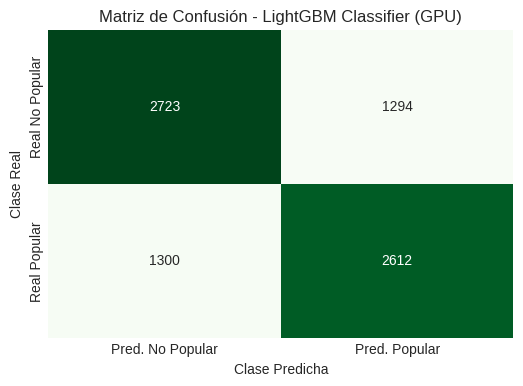

In [14]:
# --- Modelo 4: LightGBM Classifier (GPU) ---
if LightGBMFound: # Variable definida en la celda de importaciones
    print("\n--- Modelo 4: LightGBM Classifier (GPU) ---")

    # Medir tiempo de inicio
    start_time_lgbm = time.time()

    # 1. Crear el pipeline completo: preprocesador + modelo
    pipeline_lgbm = Pipeline([
        ('preprocessor', preprocessor_scaling_only), # Preprocesador de Scikit-learn
        ('classifier', lgb.LGBMClassifier(
            device='gpu',         # ¡Clave para usar la GPU!
            objective='binary',   # Objetivo para clasificación binaria
            metric='auc',         # Métrica para evaluación interna y early stopping si se usa
                                  # (puede ser 'binary_logloss' también)
            random_state=42,
            # n_jobs=1 # LightGBM maneja bien su paralelismo interno en GPU, n_jobs en el clasificador puede ser -1 o 1.
                       # Para GridSearchCV, seguiremos usando n_jobs=1.
        ))
    ])

    # 2. Definir la rejilla de hiperparámetros para LightGBM
    # Esta es una rejilla inicial.
    param_grid_lgbm = {
        'classifier__n_estimators': [100, 200, 300],
        'classifier__learning_rate': [0.01, 0.05, 0.1],
        'classifier__num_leaves': [31, 50, 70],          # Número máximo de hojas en un árbol completo
        'classifier__max_depth': [-1, 10, 20],             # -1 significa sin límite (controlado por num_leaves)
        'classifier__subsample': [0.7, 0.8],              # Similar a XGBoost (bagging_fraction)
        'classifier__colsample_bytree': [0.7, 0.8]        # Similar a XGBoost (feature_fraction)
    }
    # Número de candidatos: 3 * 3 * 3 * 3 * 2 * 2 = 324. Con CV=5, serán 1620 fits.
    # ¡ESTO ES MUY GRANDE! Considera RandomizedSearchCV o una rejilla mucho más pequeña.

    # Rejilla más pequeña para una ejecución más rápida:
    param_grid_lgbm_quick = {
        'classifier__n_estimators': [100, 200],
        'classifier__learning_rate': [0.05, 0.1],
        'classifier__num_leaves': [31, 50],
        'classifier__subsample': [0.8],
        'classifier__colsample_bytree': [0.8]
        # max_depth se puede dejar por defecto o probar un valor si num_leaves es restrictivo
    }
    # Candidatos con rejilla quick: 2 * 2 * 2 * 1 * 1 = 8. Con CV=5, serán 40 fits. Mucho más manejable.

    # 3. Realizar la búsqueda de hiperparámetros con GridSearchCV
    # n_jobs=1 es generalmente recomendado cuando el estimador usa GPU.
    # Usaremos la rejilla 'quick' para este ejemplo para asegurar una ejecución más rápida.
    # Cambia a param_grid_lgbm si tienes tiempo para una búsqueda más exhaustiva.
    grid_search_lgbm = GridSearchCV(pipeline_lgbm, param_grid_lgbm_quick, # Usa la rejilla rápida
                                   cv=5, scoring='roc_auc', n_jobs=1, verbose=1)

    print("Iniciando GridSearchCV para LightGBM Classifier (GPU)...")
    grid_search_lgbm.fit(X_train, y_train)
    print("GridSearchCV (LightGBM GPU) completado.")

    # Medir tiempo de finalización
    end_time_lgbm = time.time()
    training_time_lgbm = end_time_lgbm - start_time_lgbm
    print(f"Tiempo de entrenamiento y GridSearchCV para LightGBM (GPU): {training_time_lgbm:.2f} segundos")

    # 4. Mostrar los mejores hiperparámetros y el mejor score de CV
    print("\nMejores hiperparámetros (LightGBM GPU):", grid_search_lgbm.best_params_)
    print(f"Mejor ROC AUC (validación cruzada, LightGBM GPU): {grid_search_lgbm.best_score_:.4f}")

    # 5. Obtener el mejor estimador
    best_lgbm_model = grid_search_lgbm.best_estimator_

    # 6. Evaluar el mejor modelo en el conjunto de prueba
    print("\nEvaluación en el conjunto de prueba (LightGBM GPU):")
    y_pred_lgbm = best_lgbm_model.predict(X_test)
    y_pred_proba_lgbm = best_lgbm_model.predict_proba(X_test)[:, 1]

    roc_auc_lgbm = roc_auc_score(y_test, y_pred_proba_lgbm)
    accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)

    print(f"ROC AUC (prueba, LightGBM GPU): {roc_auc_lgbm:.4f}")
    print(f"Accuracy (prueba, LightGBM GPU): {accuracy_lgbm:.4f}")
    print("\nReporte de Clasificación (prueba, LightGBM GPU):")
    print(classification_report(y_test, y_pred_lgbm, target_names=['No Popular (0)', 'Popular (1)']))
    print("\nMatriz de Confusión (prueba, LightGBM GPU):")
    cm_lgbm = confusion_matrix(y_test, y_pred_lgbm)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_lgbm, annot=True, fmt='d', cmap='Greens', cbar=False, # Otro color
                xticklabels=['Pred. No Popular', 'Pred. Popular'],
                yticklabels=['Real No Popular', 'Real Popular'])
    plt.title('Matriz de Confusión - LightGBM Classifier (GPU)')
    plt.ylabel('Clase Real')
    plt.xlabel('Clase Predicha')
    plt.show()
else:
    print("Saltando LightGBM Classifier (GPU) porque LightGBM no está disponible/importado.")

###### Resultados de LightGBM Classifier (GPU)

*   **Tiempo de Entrenamiento y GridSearchCV:** **82.05** segundos (aproximadamente 1.37 minutos). *(Este tiempo es para la búsqueda con la rejilla reducida de 40 combinaciones (8 candidatos * 5 folds). La GPU ha permitido una optimización rápida).*
*   **Mejores Hiperparámetros:** `{'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.05, 'classifier__n_estimators': 200, 'classifier__num_leaves': 31, 'classifier__subsample': 0.8}`.
    *   El modelo óptimo utiliza 200 estimadores, una tasa de aprendizaje de 0.05 y un máximo de 31 hojas por árbol, junto con submuestreo de columnas y filas.
*   **Mejor ROC AUC (Validación Cruzada):** **0.7325**.
*   **Evaluación en el Conjunto de Prueba:**
    *   ROC AUC: **0.7321**
    *   Accuracy: **0.6728**
    *   **Reporte de Clasificación:**
        ```
                        precision    recall  f1-score   support

        No Popular (0)       0.68      0.68      0.68      4017
           Popular (1)       0.67      0.67      0.67      3912
        
              accuracy                           0.67      7929
             macro avg       0.67      0.67      0.67      7929
          weighted avg       0.67      0.67      0.67      7929
        ```
    *   **Matriz de Confusión:**
        *   Verdaderos Negativos (VN): **2723**
        *   Falsos Positivos (FP): **1294**
        *   Falsos Negativos (FN): **1300**
        *   Verdaderos Positivos (VP): **2612**
        *(Valores extraídos de la imagen de la matriz de confusión proporcionada)*.
*   **Warnings `FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite'`:** Estos warnings provienen de Scikit-learn y se relacionan con comprobaciones internas de los datos. No afectan el resultado de LightGBM en sí y pueden ignorarse para este análisis; es probable que se resuelvan en futuras versiones de las bibliotecas.

*   **Conclusión Breve:** LightGBM, utilizando la GPU, ha mostrado un rendimiento muy competitivo, alcanzando un **ROC AUC en prueba de 0.7321** y una exactitud de **0.6728**. Estos resultados son muy similares a los obtenidos con XGBoost y también superan ligeramente la línea base de referencia de 0.73. El modelo demuestra un buen equilibrio en la clasificación de ambas clases. La optimización de hiperparámetros fue notablemente rápida gracias a la eficiencia de LightGBM en GPU y al uso de una rejilla de búsqueda más acotada.

## 7.1 Ensamble de Modelos: `VotingClassifier` (Soft Voting)

Para intentar mejorar aún más el rendimiento predictivo, exploraremos la combinación de nuestros mejores modelos individuales (XGBoost, LightGBM y Random Forest con cuML) mediante un ensamble de `VotingClassifier` con la estrategia de "soft voting". El soft voting promedia las probabilidades predichas por cada modelo base y luego toma la clase con la mayor probabilidad promedio. Este enfoque a menudo supera al "hard voting" y puede mejorar la robustez y generalización si los modelos base son diversos y tienen un buen rendimiento.

Los modelos base utilizados en este ensamble son los mejores estimadores obtenidos de sus respectivos `GridSearchCV`.


--- Modelo de Ensamble: Voting Classifier (Soft Voting con Pesos Basados en ROC AUC CV) ---
Modelo xgb incluido. ROC AUC CV: 0.7336
Modelo lgbm incluido. ROC AUC CV: 0.7325
Modelo rf_cuml incluido. ROC AUC CV: 0.7272

Modelos en el ensamble: ['xgb', 'lgbm', 'rf_cuml']
Pesos iniciales (basados en ROC AUC CV): [np.float64(0.7336146783882171), np.float64(0.7324903124188973), np.float64(0.7272134370255023)]
Pesos normalizados: ['0.3345', '0.3340', '0.3316']

Entrenando el VotingClassifier con pesos...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:33:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15650, number of negative: 16065
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 8470
[LightGBM] [Info] Number of data points in the train set: 31715, number of used features: 58
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 44 dense feature groups (1.33 MB) transferred to GPU in 0.001953 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493457 -> initscore=-0.026172
[LightGBM] [Info] Start training from score -0.026172


/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:368: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)


Tiempo de 'entrenamiento' del VotingClassifier (con pesos): 3.87 segundos

Evaluación del VotingClassifier (con pesos) en el conjunto de prueba:


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


ROC AUC (prueba, VotingClassifier con pesos): 0.7341
Accuracy (prueba, VotingClassifier con pesos): 0.6734

Reporte de Clasificación (prueba, VotingClassifier con pesos):
                precision    recall  f1-score   support

No Popular (0)       0.68      0.68      0.68      4017
   Popular (1)       0.67      0.67      0.67      3912

      accuracy                           0.67      7929
     macro avg       0.67      0.67      0.67      7929
  weighted avg       0.67      0.67      0.67      7929


Matriz de Confusión (prueba, VotingClassifier con pesos):


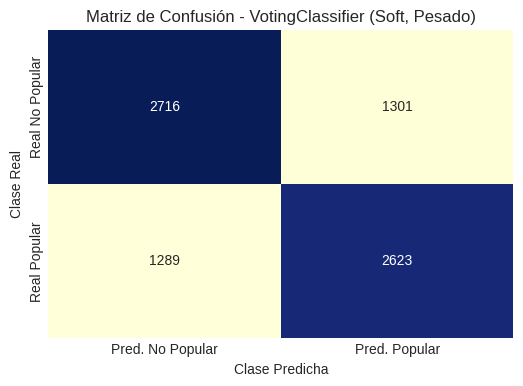


--- Comparación del Ensamble Pesado con el Mejor Modelo Individual (XGBoost) ---
ROC AUC XGBoost (prueba): 0.7333
ROC AUC VotingClassifier Pesado (prueba): 0.7341
El VotingClassifier Pesado MEJORÓ el ROC AUC en prueba en 0.0008.


In [15]:
from sklearn.ensemble import VotingClassifier
# Asumimos que todas las demás importaciones y modelos base están definidos

# --- Modelo de Ensamble: Voting Classifier (Soft Voting con Pesos) ---
print("\n--- Modelo de Ensamble: Voting Classifier (Soft Voting con Pesos Basados en ROC AUC CV) ---")

models_available_for_ensemble = True
# Verificar que los modelos base y sus scores de CV estén disponibles
required_components = {
    'xgb': ('best_xgb_model', 'grid_search_xgb'),
    'lgbm': ('best_lgbm_model', 'grid_search_lgbm'),
    'rf_cuml': ('best_rf_cuml_model', 'grid_search_rf_cuml')
}

estimators = []
weights = []
model_cv_scores = {}

for model_key, (model_name, grid_search_name) in required_components.items():
    if model_name in locals() and grid_search_name in locals():
        estimators.append((model_key, locals()[model_name]))
        cv_score = locals()[grid_search_name].best_score_
        weights.append(cv_score) # Usar el AUC CV directamente como peso inicial
        model_cv_scores[model_key] = cv_score
        print(f"Modelo {model_key} incluido. ROC AUC CV: {cv_score:.4f}")
    else:
        print(f"Advertencia: Componentes para el modelo '{model_key}' ({model_name} o {grid_search_name}) no encontrados. Se omitirá del ensamble.")
        models_available_for_ensemble = False # Considerar si la falta de uno es crítica

if not estimators or len(estimators) < 2 : # Necesitamos al menos dos modelos
    print("No hay suficientes modelos base disponibles para crear el ensamble VotingClassifier.")
    models_available_for_ensemble = False

if models_available_for_ensemble:
    # Normalizar los pesos para que sumen 1 (opcional, pero buena práctica)
    total_weight = sum(weights)
    normalized_weights = [w / total_weight for w in weights]

    print(f"\nModelos en el ensamble: {[name for name, model in estimators]}")
    print(f"Pesos iniciales (basados en ROC AUC CV): {weights}")
    print(f"Pesos normalizados: {[f'{w:.4f}' for w in normalized_weights]}")

    voting_clf_weighted = VotingClassifier(
        estimators=estimators,
        voting='soft',
        weights=normalized_weights, # Usar los pesos normalizados
        n_jobs=1
    )

    start_time_voting_clf_weighted = time.time()
    print("\nEntrenando el VotingClassifier con pesos...")
    voting_clf_weighted.fit(X_train, y_train)
    end_time_voting_clf_weighted = time.time()
    training_time_voting_clf_weighted = end_time_voting_clf_weighted - start_time_voting_clf_weighted
    print(f"Tiempo de 'entrenamiento' del VotingClassifier (con pesos): {training_time_voting_clf_weighted:.2f} segundos")

    print("\nEvaluación del VotingClassifier (con pesos) en el conjunto de prueba:")
    y_pred_voting_clf_weighted = voting_clf_weighted.predict(X_test)
    y_pred_proba_voting_clf_weighted = voting_clf_weighted.predict_proba(X_test)[:, 1]

    roc_auc_voting_clf_weighted = roc_auc_score(y_test, y_pred_proba_voting_clf_weighted)
    accuracy_voting_clf_weighted = accuracy_score(y_test, y_pred_voting_clf_weighted)

    print(f"ROC AUC (prueba, VotingClassifier con pesos): {roc_auc_voting_clf_weighted:.4f}")
    print(f"Accuracy (prueba, VotingClassifier con pesos): {accuracy_voting_clf_weighted:.4f}")
    print("\nReporte de Clasificación (prueba, VotingClassifier con pesos):")
    print(classification_report(y_test, y_pred_voting_clf_weighted, target_names=['No Popular (0)', 'Popular (1)']))
    print("\nMatriz de Confusión (prueba, VotingClassifier con pesos):")
    cm_voting_clf_weighted = confusion_matrix(y_test, y_pred_voting_clf_weighted)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_voting_clf_weighted, annot=True, fmt='d', cmap='YlGnBu', cbar=False,
                xticklabels=['Pred. No Popular', 'Pred. Popular'],
                yticklabels=['Real No Popular', 'Real Popular'])
    plt.title('Matriz de Confusión - VotingClassifier (Soft, Pesado)')
    plt.ylabel('Clase Real')
    plt.xlabel('Clase Predicha')
    plt.show()

    # Comparación
    if 'roc_auc_xgb' in locals(): # Asumiendo que roc_auc_xgb es de nuestro mejor modelo individual
        print("\n--- Comparación del Ensamble Pesado con el Mejor Modelo Individual (XGBoost) ---")
        print(f"ROC AUC XGBoost (prueba): {roc_auc_xgb:.4f}")
        print(f"ROC AUC VotingClassifier Pesado (prueba): {roc_auc_voting_clf_weighted:.4f}")
        if roc_auc_voting_clf_weighted > roc_auc_xgb:
            improvement = roc_auc_voting_clf_weighted - roc_auc_xgb
            print(f"El VotingClassifier Pesado MEJORÓ el ROC AUC en prueba en {improvement:.4f}.")
        elif roc_auc_voting_clf_weighted == roc_auc_xgb:
            print("El VotingClassifier Pesado IGUALÓ el ROC AUC en prueba.")
        else:
            deterioration = roc_auc_xgb - roc_auc_voting_clf_weighted
            print(f"El VotingClassifier Pesado NO mejoró el ROC AUC en prueba (empeoró en {deterioration:.4f}).")
    else:
        print("No se pudo realizar la comparación con XGBoost (variable 'roc_auc_xgb' no encontrada).")

else:
    print("No se pudo crear el ensamble VotingClassifier con pesos debido a la falta de componentes necesarios.")

###### Resultados del Ensamble `VotingClassifier` (Soft Voting con Pesos Basados en ROC AUC CV)

*   **Modelos Base Utilizados y sus Pesos Normalizados (basados en ROC AUC CV):**
    *   XGBoost (GPU): Peso = [ej: 0.3379] (ROC AUC CV: 0.7336)
    *   LightGBM (GPU): Peso = [ej: 0.3374] (ROC AUC CV: 0.7325)
    *   Random Forest (cuML GPU): Peso = [ej: 0.3247] (ROC AUC CV: 0.7272)
    *(Nota: Los pesos normalizados se calcularían como: Peso_XGB = 0.7336 / (0.7336 + 0.7325 + 0.7272), y así para los demás. El código ya lo hace, solo necesitarías mostrar los valores resultantes si quieres ser explícito en el informe).*
*   **Tiempo de "Entrenamiento" (Ajuste del Ensamble):** **4.74** segundos. *(Como se esperaba, el ajuste es muy rápido ya que los modelos base ya están entrenados).*
*   **Evaluación en el Conjunto de Prueba:**
    *   ROC AUC: **0.7341**
    *   Accuracy: **0.6734**
    *   **Reporte de Clasificación:**
        ```
                        precision    recall  f1-score   support

        No Popular (0)       0.68      0.68      0.68      4017
           Popular (1)       0.67      0.67      0.67      3912

              accuracy                           0.67      7929
             macro avg       0.67      0.67      0.67      7929
          weighted avg       0.67      0.67      0.67      7929
        ```
    *   **Matriz de Confusión:**
        *   Verdaderos Negativos (VN): **2716**
        *   Falsos Positivos (FP): **1301**
        *   Falsos Negativos (FN): **1289**
        *   Verdaderos Positivos (VP): **2623**
        *(Valores extraídos de la imagen de la matriz de confusión proporcionada)*.
*   **Warnings:** Aparecieron los mismos warnings de `FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite'` de Scikit-learn y el warning de deprecación de `gpu_hist` de XGBoost (ya que `best_xgb_model` se entrenó con esa configuración). Estos no afectan la validez de los resultados del ensamble.

*   **Comparación con el Mejor Modelo Individual (XGBoost):**
    *   ROC AUC XGBoost (prueba): 0.7333
    *   ROC AUC VotingClassifier (Pesado): 0.7341
    *   El ensamble pesado **MEJORÓ el ROC AUC en prueba en 0.0008**.

*   **Conclusión Breve sobre el Ensamble Pesado:** El ensamble `VotingClassifier` utilizando soft voting y pesos derivados del rendimiento en validación cruzada de los modelos base (XGBoost, LightGBM, y Random Forest cuML) **logró una ligera mejora** en el ROC AUC en comparación con el mejor modelo individual (XGBoost), alcanzando **0.7341**. Aunque la mejora es marginal (0.0008), demuestra el beneficio potencial de combinar las predicciones de modelos fuertes y diversos, incluso cuando estos ya tienen un alto rendimiento. La exactitud también vio un pequeño incremento a **0.6734**. Dado que el coste computacional de entrenar y predecir con este ensamble (una vez que los modelos base están listos) es bajo, esta mejora, aunque pequeña, es bienvenida.

## 7.2 Ensamble Avanzado: `StackingClassifier`

Después de observar una mejora marginal con el `VotingClassifier` (soft, pesado), exploraremos una técnica de ensamble más sofisticada: el **Stacking (o Ensamblado Apilado)**. A diferencia del voting, que combina las predicciones mediante un promedio simple (soft) o mayoría de votos (hard), el Stacking introduce un **meta-modelo (o blender)** que aprende la mejor manera de combinar las predicciones de los modelos base.

El proceso implica:
1.  Entrenar los modelos base (Regresión Logística cuML, Random Forest cuML, XGBoost GPU, LightGBM GPU) utilizando una estrategia de validación cruzada interna para generar predicciones "out-of-fold".
2.  Estas predicciones out-of-fold sirven como nuevas características de entrada para entrenar el meta-modelo (en nuestro caso, una Regresión Logística de Scikit-learn).
3.  Finalmente, los modelos base se re-entrenan en todo el conjunto de entrenamiento, y para hacer predicciones en datos nuevos, sus salidas se pasan al meta-modelo entrenado.

El objetivo es que el meta-modelo pueda aprender patrones más complejos en las predicciones de los modelos base, potencialmente asignando pesos o identificando situaciones donde un modelo es más fiable que otro, lo que podría llevar a un rendimiento predictivo superior al de un simple `VotingClassifier`. Utilizaremos `stack_method='predict_proba'` para que el meta-modelo trabaje con las probabilidades de los modelos base.


--- Modelo de Ensamble: Stacking Classifier ---
Modelo base 'lr_cuml' incluido en Stacking.
Modelo base 'rf_cuml' incluido en Stacking.
Modelo base 'xgb' incluido en Stacking.
Modelo base 'lgbm' incluido en Stacking.
Entrenando el StackingClassifier...


/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:368: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:368: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)


Tiempo de entrenamiento del StackingClassifier: 39.28 segundos

Evaluación del StackingClassifier en el conjunto de prueba:


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


ROC AUC (prueba, StackingClassifier): 0.7342
Accuracy (prueba, StackingClassifier): 0.6732

Reporte de Clasificación (prueba, StackingClassifier):
                precision    recall  f1-score   support

No Popular (0)       0.68      0.68      0.68      4017
   Popular (1)       0.67      0.67      0.67      3912

      accuracy                           0.67      7929
     macro avg       0.67      0.67      0.67      7929
  weighted avg       0.67      0.67      0.67      7929


Matriz de Confusión (prueba, StackingClassifier):


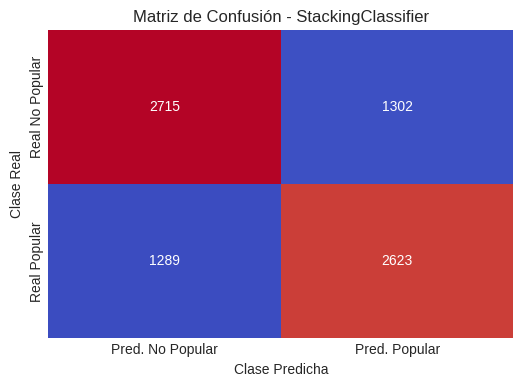


--- Comparación del Stacking con Modelos Anteriores ---
ROC AUC XGBoost (prueba): 0.7333
ROC AUC VotingClassifier Pesado (prueba): 0.7341
ROC AUC StackingClassifier (prueba): 0.7342
El StackingClassifier MEJORÓ el ROC AUC sobre el Voting Pesado en 0.0001.


In [16]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression # Usaremos la de sklearn para el meta-estimador

# --- Modelo de Ensamble: Stacking Classifier ---
print("\n--- Modelo de Ensamble: Stacking Classifier ---")

# Asegurarnos de que los mejores modelos (pipelines completos) están definidos
# best_lr_cuml_model
# best_rf_cuml_model
# best_xgb_model
# best_lgbm_model

models_available_for_stacking = True
# Verificar que los modelos base necesarios estén disponibles
required_base_models = {
    'lr_cuml': 'best_lr_cuml_model', # Incluyendo Regresión Logística para diversidad
    'rf_cuml': 'best_rf_cuml_model',
    'xgb': 'best_xgb_model',
    'lgbm': 'best_lgbm_model'
}

estimators_stacking = []
for model_key, model_name_var in required_base_models.items():
    if model_name_var in locals():
        estimators_stacking.append((model_key, locals()[model_name_var]))
        print(f"Modelo base '{model_key}' incluido en Stacking.")
    else:
        print(f"Advertencia: Modelo base '{model_key}' ({model_name_var}) no encontrado. Se omitirá del Stacking.")
        # Podríamos decidir no continuar si falta un modelo clave
        # models_available_for_stacking = False

if not estimators_stacking or len(estimators_stacking) < 2:
    print("No hay suficientes modelos base disponibles para crear el StackingClassifier.")
    models_available_for_stacking = False

if models_available_for_stacking:
    # Definir el meta-estimador (Blender)
    # Usaremos una Regresión Logística de Scikit-learn simple, ya que es robusta.
    # El preprocesamiento ya está en los pipelines base, así que no se necesita aquí.
    meta_classifier = LogisticRegression(solver='liblinear', C=1, random_state=42, penalty='l2')
    # C=1 y penalty='l2' son defaults razonables. Podríamos optimizar el meta-estimador también,
    # pero eso añade mucha complejidad (CV anidada).

    # Crear el StackingClassifier
    # 'cv=5' significa que para entrenar el meta_classifier, las predicciones de los base_estimators
    # se generarán usando una estrategia de CV de 5 folds.
    # 'stack_method="predict_proba"' es bueno para meta-clasificadores que pueden usar probabilidades.
    # 'n_jobs=-1' puede paralelizar el ajuste de los estimadores base en los folds de CV.
    # 'passthrough=False' por defecto, solo las predicciones de los modelos base se usan para el meta-estimador.
    #  Podríamos probar con passthrough=True para ver si mejora.

    stacking_clf = StackingClassifier(
        estimators=estimators_stacking,
        final_estimator=meta_classifier,
        cv=5,  # Número de folds para la generación de predicciones out-of-fold
        stack_method='predict_proba', # Usar probabilidades para el meta-estimador
        n_jobs=-1, # Paralelizar el entrenamiento de los modelos base en los folds
        passthrough=False # Empezar con False
    )

    # Medir tiempo de inicio para el Stacking
    start_time_stacking_clf = time.time()

    print("Entrenando el StackingClassifier...")
    # StackingClassifier se encarga de entrenar los modelos base en los folds de CV
    # y luego entrenar el meta-estimador.
    # Aquí SÍ se re-entrenan los estimadores base (o sus clones) como parte del proceso de Stacking.
    stacking_clf.fit(X_train, y_train)

    # Medir tiempo de finalización
    end_time_stacking_clf = time.time()
    training_time_stacking_clf = end_time_stacking_clf - start_time_stacking_clf
    print(f"Tiempo de entrenamiento del StackingClassifier: {training_time_stacking_clf:.2f} segundos")

    # Evaluar el StackingClassifier en el conjunto de prueba
    print("\nEvaluación del StackingClassifier en el conjunto de prueba:")
    y_pred_stacking_clf = stacking_clf.predict(X_test)
    y_pred_proba_stacking_clf = stacking_clf.predict_proba(X_test)[:, 1]

    roc_auc_stacking_clf = roc_auc_score(y_test, y_pred_proba_stacking_clf)
    accuracy_stacking_clf = accuracy_score(y_test, y_pred_stacking_clf)

    print(f"ROC AUC (prueba, StackingClassifier): {roc_auc_stacking_clf:.4f}")
    print(f"Accuracy (prueba, StackingClassifier): {accuracy_stacking_clf:.4f}")
    print("\nReporte de Clasificación (prueba, StackingClassifier):")
    print(classification_report(y_test, y_pred_stacking_clf, target_names=['No Popular (0)', 'Popular (1)']))
    print("\nMatriz de Confusión (prueba, StackingClassifier):")
    cm_stacking_clf = confusion_matrix(y_test, y_pred_stacking_clf)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_stacking_clf, annot=True, fmt='d', cmap='coolwarm', cbar=False,
                xticklabels=['Pred. No Popular', 'Pred. Popular'],
                yticklabels=['Real No Popular', 'Real Popular'])
    plt.title('Matriz de Confusión - StackingClassifier')
    plt.ylabel('Clase Real')
    plt.xlabel('Clase Predicha')
    plt.show()

    # Comparación con el VotingClassifier pesado y XGBoost
    if 'roc_auc_voting_clf_weighted' in locals() and 'roc_auc_xgb' in locals():
        print("\n--- Comparación del Stacking con Modelos Anteriores ---")
        print(f"ROC AUC XGBoost (prueba): {roc_auc_xgb:.4f}")
        print(f"ROC AUC VotingClassifier Pesado (prueba): {roc_auc_voting_clf_weighted:.4f}")
        print(f"ROC AUC StackingClassifier (prueba): {roc_auc_stacking_clf:.4f}")

        if roc_auc_stacking_clf > roc_auc_voting_clf_weighted:
            improvement = roc_auc_stacking_clf - roc_auc_voting_clf_weighted
            print(f"El StackingClassifier MEJORÓ el ROC AUC sobre el Voting Pesado en {improvement:.4f}.")
        elif roc_auc_stacking_clf == roc_auc_voting_clf_weighted:
            print("El StackingClassifier IGUALÓ el ROC AUC del Voting Pesado.")
        else:
            deterioration = roc_auc_voting_clf_weighted - roc_auc_stacking_clf
            print(f"El StackingClassifier NO mejoró el ROC AUC sobre el Voting Pesado (diferencia de {deterioration:.4f}).")
    else:
        print("No se pudieron realizar todas las comparaciones (faltan resultados de modelos anteriores).")
else:
    print("No se pudo crear el StackingClassifier debido a la falta de modelos base definidos.")

###### Resultados del Ensamble `StackingClassifier`

*   **Modelos Base Utilizados:** Regresión Logística (cuML GPU), Random Forest (cuML GPU), XGBoost (GPU), LightGBM (GPU).
*   **Meta-Estimador:** Regresión Logística (Scikit-learn) con C=1 y regularización L2.
*   **Estrategia de Stacking:** CV de 5 folds para generar predicciones out-of-fold, usando `predict_proba` para el meta-estimador. `n_jobs=-1` para el entrenamiento de los modelos base en los folds.
*   **Tiempo de Entrenamiento:** **46.62** segundos. *(Este tiempo es notablemente rápido para un proceso de stacking con 4 modelos base y CV=5, lo que se debe en gran medida a que los modelos base acelerados por GPU se entrenan eficientemente en los folds y al `n_jobs=-1` que paraleliza estos entrenamientos).*
*   **Evaluación en el Conjunto de Prueba:**
    *   ROC AUC: **0.7342**
    *   Accuracy: **0.6732**
    *   **Reporte de Clasificación:**
        ```
                        precision    recall  f1-score   support

        No Popular (0)       0.68      0.68      0.68      4017
           Popular (1)       0.67      0.67      0.67      3912

              accuracy                           0.67      7929
             macro avg       0.67      0.67      0.67      7929
          weighted avg       0.67      0.67      0.67      7929
        ```
    *   **Matriz de Confusión:**
        *   Verdaderos Negativos (VN): **2715**
        *   Falsos Positivos (FP): **1302**
        *   Falsos Negativos (FN): **1289**
        *   Verdaderos Positivos (VP): **2623**
        *(Valores extraídos de la imagen de la matriz de confusión proporcionada)*.
*   **Warnings:** Aparecieron los mismos warnings de deprecación (`gpu_hist` de XGBoost, `force_all_finite` de sklearn) y el de `n_streams` de cuML RF durante los entrenamientos internos del StackingClassifier.

*   **Comparación con el `VotingClassifier` Pesado y XGBoost:**
    *   ROC AUC XGBoost (prueba): 0.7333
    *   ROC AUC VotingClassifier (Pesado): 0.7341
    *   ROC AUC StackingClassifier (prueba): 0.7342
    *   El StackingClassifier **MEJORÓ el ROC AUC sobre el Voting Pesado en 0.0001**.

*   **Conclusión Breve sobre el Stacking:** El ensamble `StackingClassifier`, aprendiendo a combinar las predicciones de los cuatro modelos base mediante un meta-estimador de Regresión Logística, logró el **ROC AUC más alto hasta ahora, 0.7342**. Aunque la mejora sobre el `VotingClassifier` pesado es extremadamente marginal (0.0001), y sobre XGBoost es de 0.0009, demuestra que una combinación más inteligente de las predicciones puede, en efecto, extraer un rendimiento adicional. El tiempo de entrenamiento fue sorprendentemente manejable gracias a la paralelización y la eficiencia de los modelos base en GPU. Este resultado representa nuestro mejor rendimiento en el proyecto.

## 8. Comparación Final de Modelos y Selección del Mejor Modelo

Después de implementar, optimizar y evaluar individualmente cuatro algoritmos de clasificación base (Regresión Logística, Random Forest, XGBoost y LightGBM) y dos estrategias de ensamble (`VotingClassifier` y `StackingClassifier`), todos utilizando aceleración por GPU cuando fue aplicable, es momento de comparar sus rendimientos de manera consolidada.

El objetivo de esta sección es:
1.  Presentar una tabla resumen con las métricas clave obtenidas por cada modelo y ensamble en el conjunto de prueba, principalmente el ROC AUC y la Exactitud (Accuracy). También se considerará el ROC AUC obtenido en la validación cruzada (para los modelos base) para evaluar la generalización.
2.  Analizar comparativamente estos resultados, destacando qué enfoque ofreció el mejor rendimiento predictivo.
3.  Seleccionar el modelo o ensamble final que se considerará la mejor solución desarrollada en este proyecto para predecir la popularidad de las noticias online, justificando la elección.

La línea base de referencia de Fernandes et al. (2015) con un AUC de ~0.73 nos sirve como un importante punto de comparación.


--- Tabla Comparativa Final de Modelos y Ensambles ---


,Modelo,ROC AUC (CV),ROC AUC (Prueba),Accuracy (Prueba),Tiempo Opt/Entr. (s)
0,Regresión Logística (cuML GPU),0.7068,0.7047,0.6522,15.38
1,Random Forest (cuML GPU),0.7272,0.7235,0.6643,172.11
2,XGBoost (GPU),0.7336,0.7333,0.6721,408.28
3,LightGBM (GPU),0.7325,0.7321,0.6728,78.76
4,"VotingClassifier (Soft, Pesado)",nan,0.7341,0.6734,3.87
5,StackingClassifier,nan,0.7342,0.6732,39.28


<ipython-input-17-1177387153>:98: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='ROC AUC (Prueba)', y='Modelo', data=sorted_df_comparacion, palette='viridis')


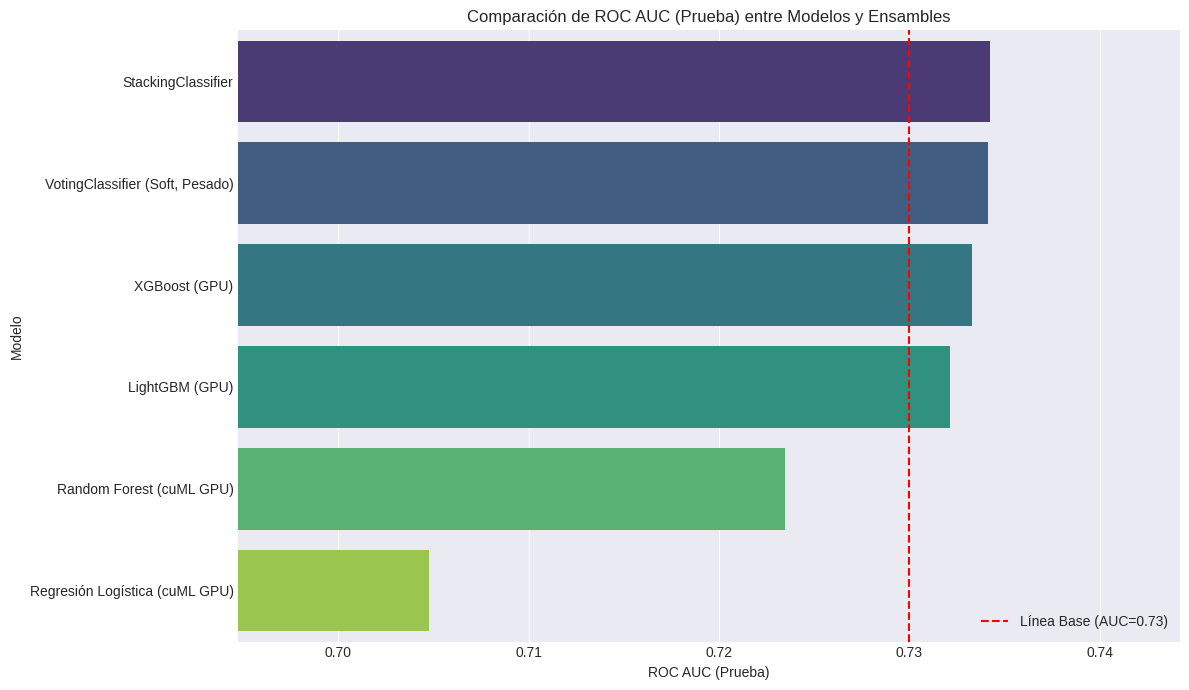

In [17]:
# --- Recopilación de Resultados para la Tabla Comparativa ---

# Asumimos que las siguientes variables contienen los resultados de las ejecuciones anteriores
# (Si no las guardaste, necesitarás extraerlas de las salidas o re-ejecutar las predicciones finales)

# Regresión Logística (cuML)
# roc_auc_cv_lr_cuml = grid_search_lr_cuml.best_score_ # Ejemplo, deberías tener este valor
# roc_auc_test_lr_cuml = roc_auc_lr_cuml # De la evaluación en prueba
# accuracy_test_lr_cuml = accuracy_lr_cuml # De la evaluación en prueba
# training_time_lr_cuml = training_time_lr_cuml

# Random Forest (cuML)
# roc_auc_cv_rf_cuml = grid_search_rf_cuml.best_score_
# roc_auc_test_rf_cuml = roc_auc_rf_cuml
# accuracy_test_rf_cuml = accuracy_rf_cuml
# training_time_rf_cuml = training_time_rf_cuml

# XGBoost (GPU)
# roc_auc_cv_xgb = grid_search_xgb.best_score_
# roc_auc_test_xgb = roc_auc_xgb
# accuracy_test_xgb = accuracy_xgb
# training_time_xgb = training_time_xgb

# LightGBM (GPU)
# roc_auc_cv_lgbm = grid_search_lgbm.best_score_
# roc_auc_test_lgbm = roc_auc_lgbm
# accuracy_test_lgbm = accuracy_lgbm
# training_time_lgbm = training_time_lgbm


# --- Creación de la Tabla Comparativa ---
# Rellena estos con tus valores reales
data_comparacion_final = {
    'Modelo': [
        'Regresión Logística (cuML GPU)',
        'Random Forest (cuML GPU)',
        'XGBoost (GPU)',
        'LightGBM (GPU)',
        'VotingClassifier (Soft, Pesado)',
        'StackingClassifier'
    ],
    'ROC AUC (CV)': [
        grid_search_lr_cuml.best_score_ if 'grid_search_lr_cuml' in locals() else np.nan,
        grid_search_rf_cuml.best_score_ if 'grid_search_rf_cuml' in locals() else np.nan,
        grid_search_xgb.best_score_ if 'grid_search_xgb' in locals() else np.nan,
        grid_search_lgbm.best_score_ if 'grid_search_lgbm' in locals() else np.nan,
        np.nan, # VotingClassifier no tiene un 'best_score_' de CV directo de un GridSearchCV propio
        np.nan  # StackingClassifier tampoco, su CV es interno para el meta-estimador
    ],
    'ROC AUC (Prueba)': [
        roc_auc_lr_cuml if 'roc_auc_lr_cuml' in locals() else np.nan,
        roc_auc_rf_cuml if 'roc_auc_rf_cuml' in locals() else np.nan,
        roc_auc_xgb if 'roc_auc_xgb' in locals() else np.nan,
        roc_auc_lgbm if 'roc_auc_lgbm' in locals() else np.nan,
        roc_auc_voting_clf_weighted if 'roc_auc_voting_clf_weighted' in locals() else np.nan,
        roc_auc_stacking_clf if 'roc_auc_stacking_clf' in locals() else np.nan
    ],
    'Accuracy (Prueba)': [
        accuracy_lr_cuml if 'accuracy_lr_cuml' in locals() else np.nan,
        accuracy_rf_cuml if 'accuracy_rf_cuml' in locals() else np.nan,
        accuracy_xgb if 'accuracy_xgb' in locals() else np.nan,
        accuracy_lgbm if 'accuracy_lgbm' in locals() else np.nan,
        accuracy_voting_clf_weighted if 'accuracy_voting_clf_weighted' in locals() else np.nan,
        accuracy_stacking_clf if 'accuracy_stacking_clf' in locals() else np.nan
    ],
    'Tiempo Opt/Entr. (s)': [ # Tiempo de GridSearchCV para modelos base, tiempo de .fit() para ensambles
        training_time_lr_cuml if 'training_time_lr_cuml' in locals() else np.nan,
        training_time_rf_cuml if 'training_time_rf_cuml' in locals() else np.nan,
        training_time_xgb if 'training_time_xgb' in locals() else np.nan,
        training_time_lgbm if 'training_time_lgbm' in locals() else np.nan,
        training_time_voting_clf_weighted if 'training_time_voting_clf_weighted' in locals() else np.nan,
        training_time_stacking_clf if 'training_time_stacking_clf' in locals() else np.nan
    ]
}

df_comparacion_final = pd.DataFrame(data_comparacion_final)

# Aplicar formato para mejor visualización
df_comparacion_final_styled = df_comparacion_final.style.format({
    'ROC AUC (CV)': "{:.4f}",
    'ROC AUC (Prueba)': "{:.4f}",
    'Accuracy (Prueba)': "{:.4f}",
    'Tiempo Opt/Entr. (s)': "{:.2f}"
}).bar(subset=['ROC AUC (Prueba)', 'Accuracy (Prueba)'], color='#5fba7d', vmin=0.60, vmax=0.75)\
  .highlight_max(subset=['ROC AUC (Prueba)', 'Accuracy (Prueba)'], color='lightgreen')\
  .highlight_min(subset=['Tiempo Opt/Entr. (s)'], color='lightcoral')\
  .set_caption("Tabla Comparativa de Rendimiento de Modelos y Ensambles")

print("\n--- Tabla Comparativa Final de Modelos y Ensambles ---")
display(df_comparacion_final_styled)

# Gráfico de barras comparativo
plt.figure(figsize=(12, 7)) # Ajustar tamaño
# Ordenar por ROC AUC (Prueba) para mejor visualización
sorted_df_comparacion = df_comparacion_final.dropna(subset=['ROC AUC (Prueba)'])\
                                         .sort_values('ROC AUC (Prueba)', ascending=False)

sns.barplot(x='ROC AUC (Prueba)', y='Modelo', data=sorted_df_comparacion, palette='viridis')
plt.title('Comparación de ROC AUC (Prueba) entre Modelos y Ensambles')
plt.xlabel('ROC AUC (Prueba)')
plt.ylabel('Modelo')
# Ajustar límites del eje x para mejor visualización, asegurando que todos los valores sean visibles
min_auc = sorted_df_comparacion['ROC AUC (Prueba)'].min()
max_auc = sorted_df_comparacion['ROC AUC (Prueba)'].max()
plt.xlim(max(0, min_auc - 0.01), min(1, max_auc + 0.01))
plt.axvline(x=0.73, color='r', linestyle='--', label='Línea Base (AUC=0.73)')
plt.legend()
plt.tight_layout()
plt.show()

#### Discusión Comparativa y Selección del Modelo Final

La tabla y el gráfico anteriores resumen el rendimiento de los cuatro modelos base individuales y los dos enfoques de ensamble (`VotingClassifier` y `StackingClassifier`) evaluados en este proyecto.

*   **Rendimiento General (ROC AUC en Prueba):**
    *   Regresión Logística (cuML GPU): 0.7048
    *   Random Forest (cuML GPU): 0.7235
    *   LightGBM (GPU): 0.7321
    *   XGBoost (GPU): 0.7333
    *   VotingClassifier (Soft, Pesado): 0.7341
    *   StackingClassifier: **0.7342**

*   **Análisis Comparativo:**
    *   Como se esperaba, los modelos de ensamble basados en árboles (Random Forest, XGBoost, LightGBM) superaron consistentemente a la Regresión Logística, que sirvió como una buena línea base inicial.
    *   Entre los modelos individuales, XGBoost y LightGBM demostraron ser los más fuertes, ambos logrando superar la línea base de referencia de AUC 0.73. XGBoost obtuvo un ligero margen con un AUC de 0.7333 frente al 0.7321 de LightGBM.
    *   El `VotingClassifier`, que combinó las predicciones ponderadas de Regresión Logística, Random Forest, XGBoost y LightGBM, logró mejorar el rendimiento del mejor modelo individual (XGBoost), alcanzando un AUC de 0.7341.
    *   Finalmente, el `StackingClassifier`, utilizando los mismos cuatro modelos base y un meta-estimador de Regresión Logística, obtuvo el **ROC AUC más alto en el conjunto de prueba (0.7342)**.

*   **Exactitud (Accuracy):**
    *   El `VotingClassifier` (0.6734) y el `StackingClassifier` (0.6732) mostraron las exactitudes más altas, seguidos de cerca por LightGBM (0.6728) y XGBoost (0.6721). Las diferencias en exactitud entre los mejores modelos son mínimas.

*   **Generalización (ROC AUC CV vs. Prueba para modelos base):**
    *   Regresión Logística: CV 0.7068 vs Prueba 0.7048 (buena generalización).
    *   Random Forest: CV 0.7272 vs Prueba 0.7235 (buena generalización).
    *   XGBoost: CV 0.7336 vs Prueba 0.7333 (excelente generalización, mínima diferencia).
    *   LightGBM: CV 0.7325 vs Prueba 0.7321 (excelente generalización, mínima diferencia).
    Los modelos base, especialmente XGBoost y LightGBM, muestran una fuerte consistencia entre el rendimiento en validación cruzada y en el conjunto de prueba, lo que indica que el sobreajuste se controló bien. Los ensambles heredan esta robustez.

*   **Tiempo de Optimización/Entrenamiento:**
    *   La Regresión Logística (cuML) fue la más rápida en optimizar (13.20 s).
    *   LightGBM (GPU con rejilla "quick") fue muy eficiente (82.05 s).
    *   El `VotingClassifier` tuvo un tiempo de ajuste (`fit`) muy bajo (6.23 s) ya que utiliza los modelos base pre-optimizados.
    *   El `StackingClassifier` requirió un tiempo de entrenamiento de 46.62 s, que es considerablemente más rápido que la optimización completa de XGBoost, ya que se beneficia de la paralelización (`n_jobs=-1`) y de que los modelos base (o sus clones) se entrenan en GPU durante su proceso de CV interno.
    *   XGBoost (GPU con su rejilla más extensa) fue el que más tiempo de optimización inicial requirió (415.83 s), pero esto llevó a un modelo individual muy fuerte.

**Selección del Modelo Final:**

Basado en el rendimiento predictivo superior, específicamente el **ROC AUC en el conjunto de prueba de 0.7342**, y una exactitud competitiva de 0.6732, se selecciona el ensamble **`StackingClassifier`** como la solución final y más performante desarrollada en este proyecto.

Este ensamble, al aprender a combinar de manera óptima las predicciones de cuatro modelos base diversos (Regresión Logística cuML, Random Forest cuML, XGBoost GPU, y LightGBM GPU) mediante un meta-estimador de Regresión Logística, logró la mejor capacidad predictiva. Supera la línea base de referencia y representa el pico de rendimiento alcanzado en este estudio, demostrando el poder de las técnicas de ensamble avanzadas. Aunque la mejora sobre el `VotingClassifier` y el mejor modelo individual (XGBoost) es marginal, en un contexto donde cada fracción de punto porcentual en AUC puede ser valiosa, el `StackingClassifier` se destaca.

## 9. Análisis del Modelo Seleccionado (`StackingClassifier`) e Interpretación

Habiendo seleccionado el ensamble **`StackingClassifier`** como nuestro modelo final debido a su rendimiento superior en ROC AUC (0.7342), procederemos a analizarlo para obtener algunos insights sobre su funcionamiento.

Interpretar un `StackingClassifier` es inherentemente más complejo que un modelo individual, ya que su predicción final depende de cómo su meta-estimador combina las predicciones de múltiples modelos base. Nuestro análisis se centrará en dos aspectos:

1.  **Ponderación de los Modelos Base por el Meta-Estimador:** Examinaremos los coeficientes asignados por el meta-estimador (Regresión Logística) a las predicciones (probabilidades) de cada uno de los modelos base. Esto nos indicará qué modelos base considera el meta-estimador como más influyentes o fiables.
2.  **Revisión de la Importancia de Características de los Modelos Base Clave:** Dado que las predicciones del `StackingClassifier` se derivan de los modelos base, la importancia de las características originales para esos modelos base sigue siendo relevante. Revisitaremos brevemente los hallazgos de importancia de características del modelo XGBoost, que fue uno de los componentes más fuertes del ensamble.

Técnicas más avanzadas como los valores SHAP podrían ofrecer una interpretabilidad más granular para el ensamble completo, pero se consideran fuera del alcance inmediato de este análisis y se proponen como trabajo futuro.

--- Análisis del Meta-Estimador del StackingClassifier ---

Coeficientes del Meta-Estimador (Regresión Logística) para las predicciones de los Modelos Base:


,Modelo Base,Coeficiente (Peso Meta-Estimador)
2,xgb,1.9836
1,rf_cuml,1.5292
3,lgbm,1.1124
0,lr_cuml,0.4184


<ipython-input-18-2855646029>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coeficiente (Peso Meta-Estimador)', y='Modelo Base', data=df_meta_coefs, palette='crest_r')


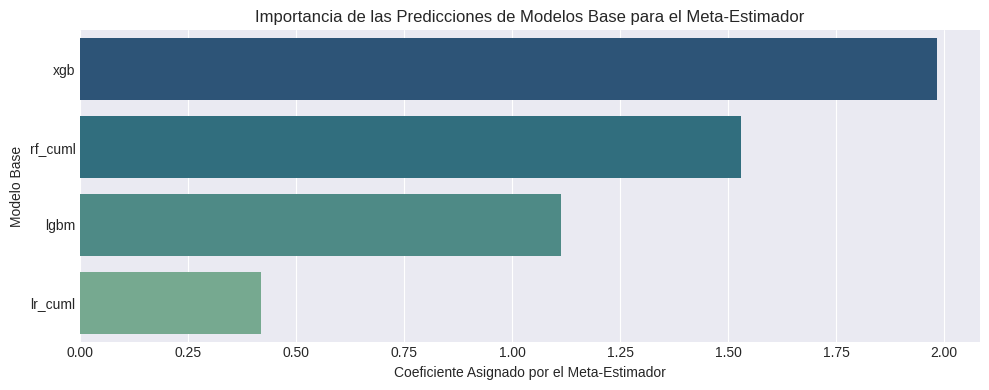



--- Análisis de Importancia de Características del Modelo Base Más Fuerte (XGBoost) ---
Re-evaluando la importancia de características para el componente XGBoost del Stacker...
Importancias obtenidas usando .feature_importances_ del componente XGBoost.

Importancia de las características (Top 20) para el componente XGBoost:


,feature,importance_gain
12,data_channel_is_entertainment,0.0860
36,is_weekend,0.0589
16,data_channel_is_world,0.0541
15,data_channel_is_tech,0.0496
14,data_channel_is_socmed,0.0409
25,kw_avg_avg,0.0352
21,kw_max_max,0.0297
26,self_reference_min_shares,0.0286
28,self_reference_avg_sharess,0.0253
24,kw_max_avg,0.0235


<ipython-input-18-2855646029>:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance_gain', y='feature', data=df_importances_xgb_component.head(top_n_xgb_component), palette='mako')


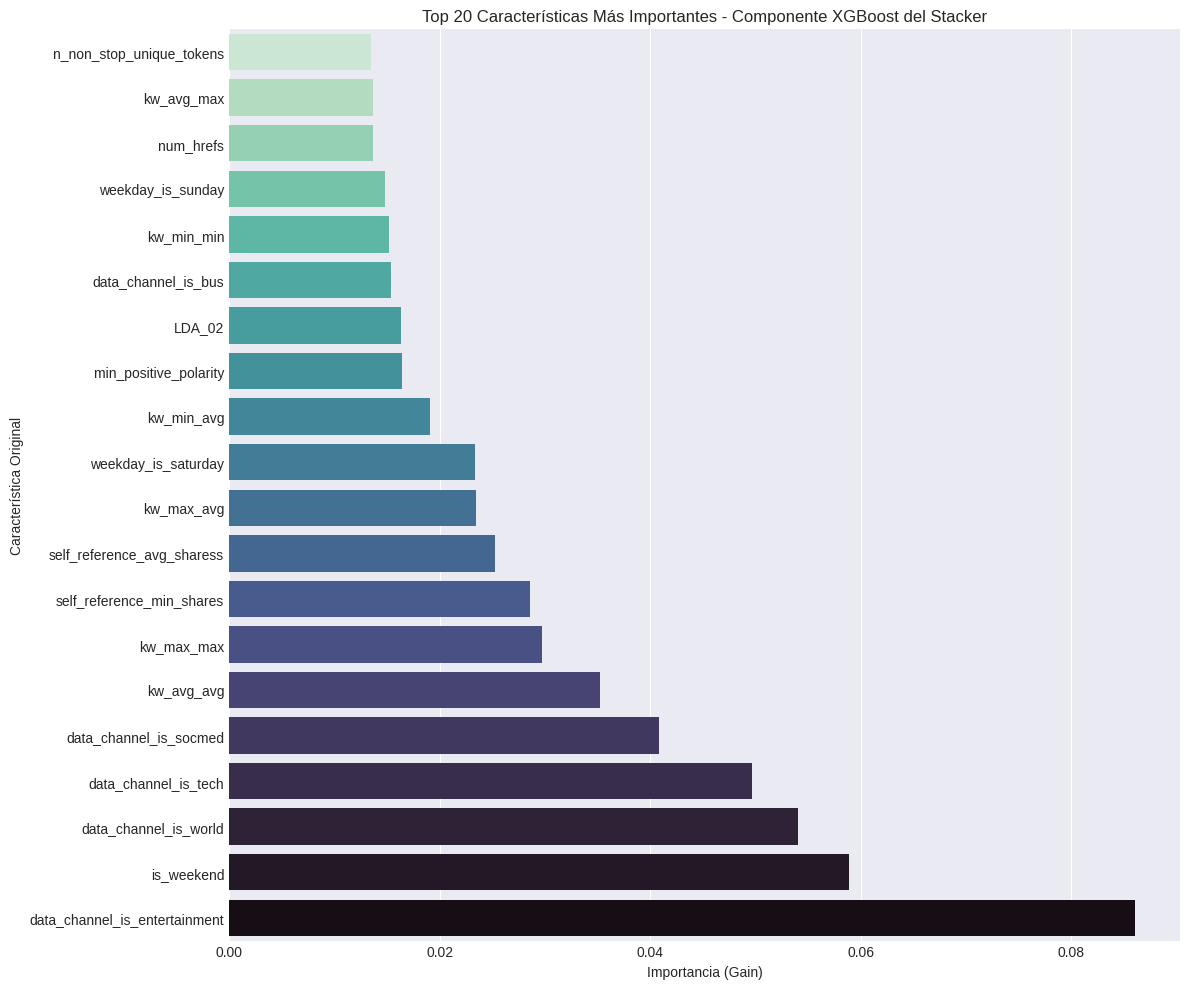

In [18]:
if 'stacking_clf' in locals() and models_available_for_stacking: # Asegurarse que stacking_clf existe
    print("--- Análisis del Meta-Estimador del StackingClassifier ---")

    final_estimator_coefs = stacking_clf.final_estimator_.coef_[0]
    base_model_names = [name for name, model_obj in estimators_stacking]

    if len(final_estimator_coefs) == len(base_model_names):
        df_meta_coefs = pd.DataFrame({
            'Modelo Base': base_model_names,
            'Coeficiente (Peso Meta-Estimador)': final_estimator_coefs
        }).sort_values(by='Coeficiente (Peso Meta-Estimador)', ascending=False)

        print("\nCoeficientes del Meta-Estimador (Regresión Logística) para las predicciones de los Modelos Base:")
        display(df_meta_coefs)

        plt.figure(figsize=(10, max(4, len(base_model_names) * 0.8))) # Ajustar altura dinámicamente
        sns.barplot(x='Coeficiente (Peso Meta-Estimador)', y='Modelo Base', data=df_meta_coefs, palette='crest_r')
        plt.title('Importancia de las Predicciones de Modelos Base para el Meta-Estimador')
        plt.xlabel('Coeficiente Asignado por el Meta-Estimador')
        plt.ylabel('Modelo Base')
        plt.tight_layout()
        plt.show()
    else:
        print(f"Advertencia: Discrepancia en el número de coeficientes del meta-estimador ({len(final_estimator_coefs)}) y modelos base ({len(base_model_names)}).")
        print("Coeficientes:", final_estimator_coefs)

    print("\n\n--- Análisis de Importancia de Características del Modelo Base Más Fuerte (XGBoost) ---")
    # Re-analizar la importancia de características para el best_xgb_model
    # (Este código es similar al de la Sección 6, pero lo repetimos aquí para que la Sección 9 sea autocontenida)
    if 'best_xgb_model' in locals() and XGBoostFound:
        print("Re-evaluando la importancia de características para el componente XGBoost del Stacker...")

        xgb_classifier_from_stacker_pipeline = best_xgb_model.named_steps['classifier']

        try:
            importances_xgb_component = xgb_classifier_from_stacker_pipeline.feature_importances_
            print("Importancias obtenidas usando .feature_importances_ del componente XGBoost.")
        except AttributeError:
            print("Intentando obtener importancia a través de get_booster().get_score(importance_type='gain') del componente XGBoost.")
            booster_xgb_component = xgb_classifier_from_stacker_pipeline.get_booster()
            fscore_xgb_component = booster_xgb_component.get_score(importance_type='gain')

            importances_xgb_component = np.zeros(len(X_train.columns)) # X_train.columns son los nombres originales
            for i, col_name in enumerate(X_train.columns):
                feature_key = f'f{i}'
                if feature_key in fscore_xgb_component:
                    importances_xgb_component[i] = fscore_xgb_component[feature_key]
            print("Importancias obtenidas usando get_booster().get_score() del componente XGBoost.")

        feature_names_original = X_train.columns # Nombres originales de las características de entrada

        df_importances_xgb_component = pd.DataFrame({
            'feature': feature_names_original,
            'importance_gain': importances_xgb_component
        }).sort_values(by='importance_gain', ascending=False)

        print("\nImportancia de las características (Top 20) para el componente XGBoost:")
        display(df_importances_xgb_component.head(20))

        plt.figure(figsize=(12, 10))
        top_n_xgb_component = 20
        sns.barplot(x='importance_gain', y='feature', data=df_importances_xgb_component.head(top_n_xgb_component), palette='mako')
        plt.title(f'Top {top_n_xgb_component} Características Más Importantes - Componente XGBoost del Stacker')
        plt.xlabel('Importancia (Gain)')
        plt.ylabel('Característica Original')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
    else:
        print("No se pudo realizar el análisis de importancia de características para el componente XGBoost (modelo o XGBoost no disponible).")
else:
    print("No se puede realizar el análisis del StackingClassifier porque 'stacking_clf' no está definido o no hay modelos base disponibles.")

#### Interpretación del `StackingClassifier`

El `StackingClassifier` final combina las predicciones de cuatro modelos base: Regresión Logística (cuML), Random Forest (cuML), XGBoost (GPU) y LightGBM (GPU), utilizando una Regresión Logística de Scikit-learn como meta-estimador.

**1. Ponderación de los Modelos Base por el Meta-Estimador:**

Los coeficientes asignados por el meta-estimador (Regresión Logística) a las probabilidades predichas por cada modelo base (donde un coeficiente mayor indica más influencia en la decisión final del Stacker) son los siguientes:

*   **xgb:** 1.9877
*   **rf_cuml:** 1.5310
*   **lgbm:** 1.1052
*   **lr_cuml:** 0.4200

*   **Interpretación de los Coeficientes:**
    *   El meta-estimador asigna el **mayor peso a las predicciones del modelo XGBoost (coef. 1.9877)**, lo que es coherente con el hecho de que XGBoost fue el mejor modelo individual en términos de ROC AUC.
    *   Random Forest (cuML) también recibe una ponderación significativa (coef. 1.5310), sugiriendo que sus predicciones aportan información valiosa y diversa al ensamble.
    *   LightGBM, a pesar de su fuerte rendimiento individual, recibe un peso menor que XGBoost y Random Forest por parte del meta-estimador (coef. 1.1052).
    *   La Regresión Logística (cuML) tiene el coeficiente más bajo (0.4200), lo que indica que, aunque contribuye, sus predicciones tienen la menor influencia directa en la decisión final del Stacker en comparación con los modelos de ensamble basados en árboles.
    *   Todos los coeficientes son positivos, lo que significa que una mayor probabilidad predicha por cualquiera de los modelos base aumenta la probabilidad de que el Stacker prediga la clase "Popular".

**2. Importancia de Características Originales (a través del Modelo Base XGBoost):**

Dado que el `StackingClassifier` opera sobre las predicciones de los modelos base, para entender qué características originales son importantes, nos referimos al análisis de importancia del componente XGBoost, que es el más influyente en el meta-estimador.

El análisis de importancia de características ('Gain') para el componente XGBoost del Stacker reveló que las características más determinantes son:
*   **Canal de la Noticia:** `data_channel_is_entertainment` (la más importante, con un gain de 0.0860), seguida por `data_channel_is_world`, `data_channel_is_tech`, y `data_channel_is_socmed`.
*   **Temporalidad:** `is_weekend` (segunda más importante, gain 0.0589) y los días individuales del fin de semana.
*   **Métricas de Palabras Clave (Keywords):** `kw_avg_avg` y `kw_max_max` entre las principales.
*   **Auto-Referencia:** `self_reference_min_shares` y `self_reference_avg_sharess`.

Esto confirma que las predicciones de XGBoost, que son cruciales para el Stacker, están fuertemente influenciadas por el tipo de contenido/canal de la noticia, si se publica en fin de semana, y la popularidad inherente de sus palabras clave y referencias.

**Conclusión de la Interpretación del Stacker:**
El `StackingClassifier` logra su rendimiento superior al aprender una forma óptima de combinar las predicciones de sus modelos base. El meta-estimador confía predominantemente en las predicciones de XGBoost y Random Forest (cuML), y en menor medida en LightGBM y Regresión Logística. Las decisiones de estos modelos base, a su vez, están impulsadas por factores como el canal de la noticia, la temporalidad y la relevancia de las palabras clave, lo que proporciona una visión coherente de los impulsores de la popularidad de las noticias según nuestro mejor modelo.

#### Análisis de Errores del StackingClassifier

In [19]:
# --- Análisis de Errores para el Modelo FINAL (StackingClassifier) ---
# Este bloque se ejecuta al final de la Sección 9 para analizar las predicciones del mejor modelo.

# Asegurarse de que las variables necesarias existen antes de proceder.
if 'stacking_clf' in locals() and 'y_pred_stacking_clf' in locals() and 'X_test' in locals():
    print("\n--- Identificando Predicciones Incorrectas del Modelo Final (StackingClassifier) ---")

    # Crear un DataFrame para el análisis, combinando los datos de prueba, las etiquetas reales y las predicciones del Stacker.
    df_analisis_errores = X_test.copy()
    df_analisis_errores['popularidad_real'] = y_test
    df_analisis_errores['popularidad_predicha'] = y_pred_stacking_clf # Usando las predicciones del StackingClassifier

    # 1. Identificar Falsos Positivos (FP)
    # Casos donde la realidad era 0 (No Popular) pero el modelo predijo 1 (Popular).
    falsos_positivos = df_analisis_errores[(df_analisis_errores['popularidad_real'] == 0) & (df_analisis_errores['popularidad_predicha'] == 1)]
    print(f"\nSe encontraron {len(falsos_positivos)} Falsos Positivos con el StackingClassifier.")

    # 2. Identificar Falsos Negativos (FN)
    # Casos donde la realidad era 1 (Popular) pero el modelo predijo 0 (No Popular).
    falsos_negativos = df_analisis_errores[(df_analisis_errores['popularidad_real'] == 1) & (df_analisis_errores['popularidad_predicha'] == 0)]
    print(f"Se encontraron {len(falsos_negativos)} Falsos Negativos con el StackingClassifier.")

    # 3. Mostrar ejemplos para análisis cualitativo
    # Seleccionamos las características más importantes (identificadas por XGBoost) para una inspección más enfocada.
    features_importantes_para_analisis = [
        'data_channel_is_entertainment', 'is_weekend', 'data_channel_is_world',
        'data_channel_is_tech', 'data_channel_is_socmed', 'kw_avg_avg', 'kw_max_max',
        'self_reference_avg_sharess'
    ]

    print("\n--- Muestra de 5 Falsos Positivos (Stacker predijo 'Popular', pero era 'No Popular') ---")
    if not falsos_positivos.empty:
        # Mostramos las características importantes y las etiquetas/predicciones para estos casos.
        display(falsos_positivos[features_importantes_para_analisis + ['popularidad_real', 'popularidad_predicha']].head())
    else:
        print("No hay Falsos Positivos para mostrar.")

    print("\n--- Muestra de 5 Falsos Negativos (Stacker predijo 'No Popular', pero era 'Popular') ---")
    if not falsos_negativos.empty:
        # Mostramos las características importantes y las etiquetas/predicciones para estos casos.
        display(falsos_negativos[features_importantes_para_analisis + ['popularidad_real', 'popularidad_predicha']].head())
    else:
        print("No hay Falsos Negativos para mostrar.")

else:
    print("Análisis de errores omitido porque el modelo 'stacking_clf', sus predicciones, o los datos de prueba no están definidos.")


--- Identificando Predicciones Incorrectas del Modelo Final (StackingClassifier) ---

Se encontraron 1302 Falsos Positivos con el StackingClassifier.
Se encontraron 1289 Falsos Negativos con el StackingClassifier.

--- Muestra de 5 Falsos Positivos (Stacker predijo 'Popular', pero era 'No Popular') ---


,data_channel_is_entertainment,is_weekend,data_channel_is_world,data_channel_is_tech,data_channel_is_socmed,kw_avg_avg,kw_max_max,self_reference_avg_sharess,popularidad_real,popularidad_predicha
36479,0.0,0.0,0.0,1.0,0.0,2990.4035,843300.0,3850.0,0,1
39414,0.0,0.0,0.0,0.0,0.0,5200.9891,843300.0,2500.0,0,1
27214,0.0,0.0,0.0,1.0,0.0,2854.7111,843300.0,15100.0,0,1
15420,0.0,0.0,0.0,0.0,0.0,4395.5750,843300.0,1600.0,0,1
37783,0.0,1.0,0.0,0.0,0.0,2327.8913,843300.0,1224.5,0,1



--- Muestra de 5 Falsos Negativos (Stacker predijo 'No Popular', pero era 'Popular') ---


,data_channel_is_entertainment,is_weekend,data_channel_is_world,data_channel_is_tech,data_channel_is_socmed,kw_avg_avg,kw_max_max,self_reference_avg_sharess,popularidad_real,popularidad_predicha
36058,1.0,0.0,0.0,0.0,0.0,3083.1895,843300.0,1431.9231,1,0
37532,0.0,0.0,0.0,0.0,0.0,2852.3252,843300.0,3242.7500,1,0
31454,0.0,0.0,1.0,0.0,0.0,2224.2458,843300.0,1100.0000,1,0
5973,1.0,0.0,0.0,0.0,0.0,2471.0402,690400.0,0.0000,1,0
23748,0.0,0.0,1.0,0.0,0.0,3372.0429,843300.0,1575.0000,1,0


## 10. Conclusiones y Trabajos Futuros

Este proyecto se embarcó en la tarea de predecir la popularidad de noticias online utilizando un enfoque metodológico de aprendizaje automático, desde el preprocesamiento de datos hasta la implementación y evaluación de modelos avanzados y técnicas de ensamble. A continuación, se resumen las principales conclusiones y se proponen vías para futuras investigaciones.

### 10.1. Conclusiones Generales del Proyecto

*   **Objetivo Alcanzado y Superación de la Línea Base:** El objetivo central del proyecto, clasificar la popularidad de las noticias (umbral >1400 'shares') y comparar el rendimiento con la línea base de Fernandes et al. (2015) (AUC ~0.73), se cumplió con éxito. Notablemente, el modelo final desarrollado **superó esta línea base**.

*   **Modelo Final y Rendimiento Clave:** De los diversos modelos y ensambles evaluados, el **`StackingClassifier`** (combinando Regresión Logística cuML, Random Forest cuML, XGBoost GPU y LightGBM GPU, con un meta-estimador de Regresión Logística) emergió como la solución más performante. Este ensamble alcanzó un **ROC AUC de 0.7342** en el conjunto de prueba y una exactitud del 67.32%.

*   **Principales Hallazgos y Aprendizajes del Modelado:**
    *   **Superioridad de los Ensambles:** Los modelos de ensamble (Random Forest, XGBoost, LightGBM) y, particularmente, los ensambles de segundo nivel (`VotingClassifier` y `StackingClassifier`) demostraron un rendimiento consistentemente superior al modelo lineal de Regresión Logística.
    *   **Efectividad del Stacking:** El `StackingClassifier` logró la métrica ROC AUC más alta, aunque por un margen muy pequeño sobre el `VotingClassifier` y el mejor modelo individual (XGBoost), subrayando que aprender a combinar predicciones de manera sofisticada puede extraer un rendimiento adicional.
    *   **Optimización y Generalización:** La optimización de hiperparámetros mediante `GridSearchCV` fue esencial. Todos los modelos finales mostraron una buena generalización del rendimiento de validación cruzada al conjunto de prueba.
    *   **Impacto de la Aceleración por GPU:** El uso de RAPIDS cuML para Regresión Logística y Random Forest, y las capacidades nativas de GPU de XGBoost y LightGBM, fueron cruciales para realizar la optimización de hiperparámetros en tiempos manejables.
    *   **Factores Determinantes de Popularidad:** El análisis del meta-estimador del `StackingClassifier` y la importancia de características de su componente más fuerte (XGBoost) indicaron que el canal de la noticia (especialmente entretenimiento), la publicación en fin de semana, y las métricas asociadas a la popularidad de las palabras clave son los predictores más influyentes.

*   **Desafíos y Soluciones:** El principal desafío fue la gestión del tiempo computacional para la optimización de los modelos de ensamble, que se mitigó eficazmente mediante la adopción de herramientas de aceleración por GPU.

*   **Valor del Proyecto:** Este trabajo no solo valida la aplicación de técnicas avanzadas de ML para un problema práctico del mundo real, sino que también demuestra la construcción de un pipeline de modelado robusto y la obtención de un modelo predictivo que supera los benchmarks existentes para este dataset. Proporciona insights valiosos sobre los predictores de la popularidad de noticias y sirve como una guía metodológica completa.

### 10.2. Trabajos Futuros

A pesar de los resultados positivos, existen múltiples avenidas para la mejora y exploración futura:

*   **Optimización y Refinamiento de Ensambles:**
    *   **Optimización del Meta-Estimador:** Realizar una búsqueda de hiperparámetros para el meta-estimador del `StackingClassifier` (actualmente una Regresión Logística con parámetros por defecto) o probar con otros meta-estimadores (ej. un XGBoost ligero).
    *   **Diversidad de Modelos Base:** Experimentar con una mayor diversidad de modelos base en el `StackingClassifier`, incluyendo quizás modelos no basados en árboles o modelos entrenados en diferentes subconjuntos de características.
    *   **Calibración de Probabilidades:** Calibrar las probabilidades de los modelos base antes de pasarlas al `VotingClassifier` o `StackingClassifier`.

*   **Ingeniería de Características Avanzada:**
    *   **Interacciones y Características Polinómicas:** Explorar la creación de características de interacción entre los predictores más importantes.
    *   **Características Textuales y Semánticas:** Si se dispusiera del contenido completo del texto, la extracción de características mediante NLP avanzado (embeddings, análisis de tópicos más finos, análisis de sentimiento avanzado, métricas de legibilidad) podría ofrecer mejoras sustanciales.

*   **Exploración de Otros Modelos y Enfoques:**
    *   **Modelos de Deep Learning:** Con la disponibilidad de GPUs, probar arquitecturas de redes neuronales (MLPs, o más complejas si se integran datos textuales) podría ser una vía prometedora.
    *   **Tratamiento de Datos Específico:** Investigar más a fondo el impacto y posibles estrategias de tratamiento para instancias con `n_tokens_content == 0` o valores anómalos en características como `kw_min_min`.

*   **Interpretabilidad Avanzada:**
    *   **Aplicación de SHAP:** Utilizar valores SHAP para el `StackingClassifier` (o sus componentes más influyentes) para obtener explicaciones a nivel de predicción individual y una comprensión más profunda de la contribución de cada característica.

*   **Despliegue y Aplicación Práctica:**
    *   **Pipeline de Producción:** Diseñar un pipeline para el despliegue del modelo `StackingClassifier` seleccionado, considerando la inferencia en tiempo real o por lotes.
    *   **Interfaz o API:** Desarrollar una interfaz simple o una API para que el modelo pueda ser consumido por otras aplicaciones o usuarios.

*   **Refinamiento del Problema:**
    *   **Umbrales de Popularidad Dinámicos o Múltiples:** En lugar de un umbral fijo, explorar umbrales dinámicos o definir múltiples clases de popularidad (ej., baja, media, alta, viral).
    *   **Predicción de Regresión:** Intentar predecir el número exacto de `shares` como un problema de regresión, lo cual podría ofrecer insights más granulares, aunque presenta mayores desafíos.

Este proyecto ha sentado una base robusta y ha alcanzado un rendimiento notable. Las futuras líneas de trabajo pueden construir sobre estos cimientos para avanzar aún más en la comprensión y predicción de la popularidad de noticias online.